### Notes on the correlation between features

In [5]:
"""
- I think we can drop the following columns ("Basic_Demos_Study_Site", "Basic_Demos_Study_Site", "MRI_Track_Scan_Location", "Basic_Demos_Enroll_Year")

- Regarding SDQ: There is Correlation between SDQ Scores and ADHD (especially 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Difficulties_Total', 
'SDQ_SDQ_Externalizing', and 'SDQ_SDQ_Hyperactivity'), but not with the Sex type (no relation). Also average and IQR values for perople with no ADHD is lower.

- Reagrding APQ: SOME OF them are right-skewed so we can apply a log transformation before normalizing. It doesn't seem to have a strong corelation between the APQ scores 
and ADHD. Also, APQ doesn't seem to be correlated with the Sex type.

- Regarding Other Clinical Measures: No significant differences or associations were found in this data with Sex type or ADHD.

- Regarding Demographic Features: Most participants are in Staten Island. The most dominant ethniticity is "not Latino". The majority race is White. 
The 1st parents moslty have collage or graduate degree, the second parent is mix. Their occupation is mixed as well, 
but with clear minority in 5-20 level jobs.

- Brain connectivity is basically the correlation between the metrics (they represents the correlation between two brain regions). 

"""

'\n- I think we can drop the following columns ("Basic_Demos_Study_Site", "Basic_Demos_Study_Site", "MRI_Track_Scan_Location", "Basic_Demos_Enroll_Year")\n\n- Regarding SDQ: There is Correlation between SDQ Scores and ADHD (especially \'SDQ_SDQ_Generating_Impact\', \'SDQ_SDQ_Difficulties_Total\', \n\'SDQ_SDQ_Externalizing\', and \'SDQ_SDQ_Hyperactivity\'), but not with the Sex type (no relation). Also average and IQR values for perople with no ADHD is lower.\n\n- Reagrding APQ: SOME OF them are right-skewed so we can apply a log transformation before normalizing. It doesn\'t seem to have a strong corelation between the APQ scores \nand ADHD. Also, APQ doesn\'t seem to be correlated with the Sex type.\n\n- Regarding Other Clinical Measures: No significant differences or associations were found in this data with Sex type or ADHD.\n\n- Regarding Demographic Features: Most participants are in Staten Island. The most dominant ethniticity is "not Latino". The majority race is White. \nThe 1s

### Import necessary python libraries

In [8]:
import numpy as np 
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import lightgbm as lgb, xgboost as xgb, catboost as cb
from gc import collect
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Target Variables 

1. **Target Variables**
  - ADHD diagnosis status (ADHD_Outcome)
  - Biological sex (Sex_F)


# Feature Variables

2. **Brain Connectivity Data**
  - fMRI connectome matrices (~19,900 features)
  - Brain region correlation values

3. **Psychological Assessment Scores**
  - Strength and Difficulties Questionnaire (SDQ) - 9 scores
  - Measures of emotional problems, behavioral issues, hyperactivity, peer problems

4. **Parenting Measures**
  - Alabama Parenting Questionnaire (APQ) - 6 scores
  - Parental discipline, involvement, monitoring styles

5. **Clinical Measures**
  - Handedness (Edinburgh Handedness Questionnaire)
  - Color vision ability

6. **Demographic Information**
  - Enrollment year
  - Study site location
  - Child's ethnicity and race
  - Parent's education level

## Questionnaire Features

### Strength and Difficulties Questionnaire (SDQ)

| Feature | Format | Range | Example | Description |
|---------|--------|-------|---------|-------------|
| **SDQ_SDQ_Conduct_Problems** | Integer | 0-10 | 3 | Measures behavior issues like fighting, lying, disobedience. A score of 3 indicates moderate behavioral problems. |
| **SDQ_SDQ_Difficulties_Total** | Integer | 0-40 | 17 | Overall score combining all problem areas. A score of 17 would indicate moderate overall difficulties. |
| **SDQ_SDQ_Emotional_Problems** | Integer | 0-10 | 4 | Measures anxiety, worry, sadness. A score of 4 indicates some emotional challenges. |
| **SDQ_SDQ_Externalizing** | Integer | 0-20 | 12 | Combines conduct problems and hyperactivity scores. A score of 12 suggests significant "acting out" behaviors. |
| **SDQ_SDQ_Generating_Impact** | Integer | 0-10 | 5 | Measures how problems affect daily life. A score of 5 means these issues moderately impact the child's functioning. |
| **SDQ_SDQ_Hyperactivity** | Integer | 0-10 | 8 | Measures restlessness, concentration issues, impulsivity. A score of 8 indicates high levels of hyperactive behavior. |
| **SDQ_SDQ_Internalizing** | Integer | 0-20 | 7 | Combines emotional and peer problems. A score of 7 indicates moderate internal struggles. |
| **SDQ_SDQ_Peer_Problems** | Integer | 0-10 | 3 | Measures friendship difficulties. A score of 3 suggests some challenges with peer relationships. |
| **SDQ_SDQ_Prosocial** | Integer | 0-10 | 7 | Measures positive social behaviors. A score of 7 indicates good prosocial skills. |

### Alabama Parenting Questionnaire (APQ)

| Feature | Format | Range | Example | Description |
|---------|--------|-------|---------|-------------|
| **APQ_P_APQ_P_CP** | Integer | 0-12 | 4 | Corporal Punishment Score. A score of 4 indicates moderate use of physical discipline. |
| **APQ_P_APQ_P_ID** | Integer | 0-28 | 13 | Inconsistent Discipline Score. A score of 13 suggests moderately inconsistent rule enforcement. |
| **APQ_P_APQ_P_INV** | Integer | 0-50 | 40 | Involvement Score. A score of 40 indicates high parental engagement. |
| **APQ_P_APQ_P_OPD** | Integer | 0-28 | 18 | Other Discipline Practices Score. A score of 18 indicates moderate use of alternative discipline approaches. |
| **APQ_P_APQ_P_PM** | Integer | 0-37 | 16 | Poor Monitoring/Supervision Score. A score of 16 suggests moderate lack of parental oversight. |
| **APQ_P_APQ_P_PP** | Integer | 0-30 | 25 | Positive Parenting Score. A score of 25 indicates strong use of positive reinforcement. |

## Other Clinical Measures

| Feature | Format | Range | Example | Description |
|---------|--------|-------|---------|-------------|
| **EHQ_EHQ_Total** | Float | -100 to +100 | 76.67 | Edinburgh Handedness score. A score of 76.67 indicates strong right-handedness. |
| **ColorVision_CV_Score** | Integer | 0-14 | 14 | Color vision test score. A perfect score of 14 indicates normal color vision. |

## Demographic Features

| Feature | Format | Range | Example | Description |
|---------|--------|-------|---------|-------------|
| **Basic_Demos_Enroll_Year** | Integer | (Study years) | 2019 | Year participant joined the study. |
| **Basic_Demos_Study_Site** | Categorical integer | Site-specific codes | 2 | Location code where the participant was tested. |
| **PreInt_Demos_Fam_Child_Ethnicity** | Categorical integer | Ethnicity codes | 0 | The child's ethnic background (e.g., 0 = Not Hispanic or Latino). |
| **PreInt_Demos_Fam_Child_Race** | Categorical integer | Race codes | 1 | The child's racial background (e.g., 1 = White). |
| **Barratt_Barratt_P1_Edu** | Categorical integer | Education codes | 5 | Parent's education level (e.g., 5 = Bachelor's degree). |

## Brain Connectivity Data (Connectome Features)

| Feature | Format | Range | Example | Description |
|---------|--------|-------|---------|-------------|
| **0throw_1stcolumn** | Float | -1 to +1 | 0.327 | Correlation between brain regions 0 and 1. A value of 0.327 indicates moderate positive correlation. |
| **5throw_8thcolumn** | Float | -1 to +1 | -0.156 | Correlation between brain regions 5 and 8. A value of -0.156 indicates weak negative correlation. |
| **12throw_19thcolumn** | Float | -1 to +1 | 0.082 | Correlation between brain regions 12 and 19. A value of 0.082 indicates very weak positive correlation. |
| **64throw_80thcolumn** | Float | -1 to +1 | 0.511 | Correlation between brain regions 64 and 80. A value of 0.511 indicates strong positive correlation. |
| **98throw_112thcolumn** | Float | -1 to +1 | -0.372 | Correlation between brain regions 98 and 112. A value of -0.372 indicates moderate negative correlation. |

## Data Patterns and Interpretation

### SDQ Score Interpretation Examples:
- A child with SDQ_SDQ_Hyperactivity = 8, SDQ_SDQ_Conduct_Problems = 5 likely shows significant ADHD symptoms
- A child with SDQ_SDQ_Emotional_Problems = 7, SDQ_SDQ_Peer_Problems = 6 might be experiencing anxiety and social isolation

### Connectome Interpretation Examples:
- Strong positive correlation (0.7) between frontal and parietal regions might indicate good executive function
- Negative correlation (-0.4) between amygdala and prefrontal regions could indicate emotional regulation difficulties

### Parenting and ADHD Connection:
- High APQ_P_APQ_P_ID (20) combined with high SDQ_SDQ_Hyperactivity (9) might suggest inconsistent discipline contributing to ADHD symptoms
- High APQ_P_APQ_P_PP (27) might be associated with better behavioral outcomes even in children with ADHD


# Load all the data from the input files
1. Training Dataset : Merge the quantitative, categorical metadata files & solution data
2. Training Dataset : Merge the quantitative, categorical metadata files

In [16]:
def get_feats(mode='train'):
    
    # Load quantitative metadata
    feats = pd.read_excel(f"Dataset/widsdatathon2025/{mode}/{mode}_QUANTITATIVE_METADATA.xlsx")
    
    # Load categorical metadata with the correct filename depending on mode
    if mode == 'TRAIN':
        cate = pd.read_excel(f"Dataset/widsdatathon2025/{mode}/{mode}_CATEGORICAL_METADATA.xlsx")
    else:
        cate = pd.read_excel(f"Dataset/widsdatathon2025/{mode}/{mode}_CATEGORICAL.xlsx")
    
    # Merge categorical data
    feats = feats.merge(cate, on='participant_id', how='left')
    
    # Load functional connectome matrices
    func = pd.read_csv(f"Dataset/widsdatathon2025/{mode}/{mode}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
    feats = feats.merge(func, on='participant_id', how='left')
    
    # If training data, merge with solution file
    if mode == 'TRAIN':
        solution = pd.read_excel("Dataset/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx")
        feats = feats.merge(solution, on='participant_id', how='left')
    
    return feats


In [18]:
%%time
# Load data
train = get_feats(mode='TRAIN')
test = get_feats(mode='TEST')

sub = pd.read_excel('Dataset/widsdatathon2025/SAMPLE_SUBMISSION.xlsx')
y = pd.read_excel(f"Dataset/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx")


# Set index
train.set_index('participant_id', inplace=True)
test.set_index('participant_id', inplace=True)

# Define targets and features
targets = ['ADHD_Outcome', 'Sex_F']
non_connectome_features = [col for col in train.columns if not (col.startswith('0') or col.startswith('1') or 
                                                             col.startswith('2') or col.startswith('3') or 
                                                             col.startswith('4') or col.startswith('5') or
                                                             col.startswith('6') or col.startswith('7') or
                                                             col.startswith('8') or col.startswith('9') or
                                                             col in targets)]

connectome_features = [col for col in train.columns if (col.startswith('0') or col.startswith('1') or 
                                                      col.startswith('2') or col.startswith('3') or 
                                                      col.startswith('4') or col.startswith('5') or
                                                      col.startswith('6') or col.startswith('7') or
                                                      col.startswith('8') or col.startswith('9'))]

CPU times: user 5.21 s, sys: 492 ms, total: 5.71 s
Wall time: 5.76 s


## BASIC DESCRIPTIVE STATISTICS

### TRAINING DATASET

In [21]:
print("Number of rows: ",train.shape[0])
print("Number of columns: ",train.shape[1])

Number of rows:  1213
Number of columns:  19929


### TESTING DATASET

In [23]:
print("Number of rows: ",test.shape[0])
print("Number of columns: ",test.shape[1])

Number of rows:  304
Number of columns:  19927


In [24]:
print("\nDataset Overview:")
print(f"Training data: {train.shape[0]} participants, {train.shape[1]} features")
print(f"Test data: {test.shape[0]} participants, {test.shape[1]} features")
print(f"Number of non-connectome features: {len(non_connectome_features)}")
print(f"Number of brain connectivity features: {len(connectome_features)}")



Dataset Overview:
Training data: 1213 participants, 19929 features
Test data: 304 participants, 19927 features
Number of non-connectome features: 27
Number of brain connectivity features: 19900


In [25]:
drop_cols = [
    "Basic_Demos_Study_Site", "Basic_Demos_Study_Site", "MRI_Track_Scan_Location", "Basic_Demos_Enroll_Year"
]

In [26]:
train.describe()


,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,...,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,58.876917,13.164880,3.781533,13.205276,39.374279,17.785655,16.393240,25.246496,2.059357,12.122836,...,-0.004378,0.001610,0.115171,0.049984,0.058144,0.093527,0.089403,0.128946,0.685078,0.342951
std,49.855501,2.780624,1.376700,3.811772,6.245928,3.764112,5.376994,3.950529,2.023322,6.577207,...,0.042900,0.047424,0.057128,0.051664,0.057674,0.054594,0.058036,0.058490,0.464676,0.474891
min,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.178688,-0.138048,-0.070094,-0.153540,-0.131455,-0.085566,-0.204160,-0.083077,0.000000,0.000000
25%,45.600000,14.000000,3.000000,11.000000,36.000000,16.000000,13.000000,23.000000,0.000000,7.000000,...,-0.033798,-0.030132,0.080291,0.015827,0.022316,0.059621,0.053224,0.090459,0.000000,0.000000
50%,76.670000,14.000000,3.000000,13.000000,40.000000,18.000000,16.000000,26.000000,2.000000,12.000000,...,-0.003724,0.000990,0.113640,0.052705,0.059151,0.093397,0.088612,0.127913,1.000000,0.000000
75%,93.400000,14.000000,4.000000,16.000000,43.000000,20.000000,19.000000,28.000000,3.000000,17.000000,...,0.024007,0.032268,0.150524,0.082526,0.095192,0.127144,0.127613,0.166523,1.000000,1.000000
max,100.000000,14.000000,12.000000,28.000000,50.000000,28.000000,37.000000,30.000000,10.000000,34.000000,...,0.180562,0.192015,0.375635,0.228748,0.322084,0.348153,0.267162,0.414304,1.000000,1.000000


In [27]:
train.head()

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
participant_id,,,,,,,,,,,,,,,,,,,,,
UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,6,...,-0.058396,-0.041544,0.142806,-0.006377,0.108005,0.148327,0.093230,-0.004984,1,1
CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,18,...,-0.025624,-0.031863,0.162011,0.067439,0.017155,0.088893,0.064094,0.194381,1,0
Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,14,...,0.010771,-0.044341,0.128386,0.047282,0.087678,0.146221,-0.009425,0.035150,1,0
p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,24,...,-0.007152,0.032584,0.121726,0.045089,0.154464,0.106817,0.065336,0.234708,1,1
M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,18,...,-0.010196,0.035638,0.074978,0.030579,0.025640,0.118199,0.112522,0.143666,1,1


AWESOME JOB ON LOADING THE DATA!!! 


# HANDLING MISSING VALUES

In [31]:
# Check for missing values in the training data
missing = train.isnull().sum()
missing_percent = 100 * missing / len(train)
missing_df = pd.DataFrame({
    'Missing Values': missing,
    'Percentage': missing_percent
})


# Display features with missing values
missing_features = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)
print("\nFeatures with missing values in training data:")
missing_features



Features with missing values in training data:


,Missing Values,Percentage
MRI_Track_Age_at_Scan,360,29.678483
PreInt_Demos_Fam_Child_Ethnicity,11,0.906843


In [32]:
# Import the imputer
from sklearn.impute import SimpleImputer

# Get the list of columns that have missing values
columns_with_missing = missing_features.index.tolist()
print(f"Number of columns with missing values: {len(columns_with_missing)}")

# Create an imputer that will replace missing values with the mean of each column
imputer = SimpleImputer(strategy='median')

# Apply the imputer only to the columns that have missing values
train[columns_with_missing] = imputer.fit_transform(train[columns_with_missing])

# Do the same for the test set if needed
test[columns_with_missing] = imputer.transform(test[columns_with_missing])

# Verify that missing values have been filled
missing_after = train[columns_with_missing].isnull().sum().sum()
print(f"Missing values after imputation: {missing_after}")
print("All missing values have been replaced with column medians")

Number of columns with missing values: 2
Missing values after imputation: 0
All missing values have been replaced with column medians


In [37]:
# Check for missing values in the testing data
missing = test.isnull().sum()
missing_percent = 100 * missing / len(test)
missing_df = pd.DataFrame({
    'Missing Values': missing,
    'Percentage': missing_percent
})


# Display features with missing values
missing_features = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)
print("\nFeatures with missing values in training data:")
missing_features



Features with missing values in training data:


,Missing Values,Percentage
Barratt_Barratt_P2_Occ,42,13.815789
Barratt_Barratt_P2_Edu,36,11.842105
SDQ_SDQ_Difficulties_Total,30,9.868421
SDQ_SDQ_Prosocial,30,9.868421
SDQ_SDQ_Peer_Problems,30,9.868421
SDQ_SDQ_Internalizing,30,9.868421
SDQ_SDQ_Hyperactivity,30,9.868421
SDQ_SDQ_Generating_Impact,30,9.868421
SDQ_SDQ_Emotional_Problems,30,9.868421
SDQ_SDQ_Externalizing,30,9.868421


In [38]:

# Categorical columns - we'll use the most common value to fill in missing data
categorical_columns = [
    'Barratt_Barratt_P1_Edu', 
    'Barratt_Barratt_P2_Edu',
    'Barratt_Barratt_P1_Occ',
    'Barratt_Barratt_P2_Occ',
    'PreInt_Demos_Fam_Child_Race'
]

# Numerical columns - we'll use the average value to fill in missing data
numerical_columns = [
    'SDQ_SDQ_Difficulties_Total',
    'SDQ_SDQ_Prosocial',
    'SDQ_SDQ_Peer_Problems',
    'SDQ_SDQ_Internalizing',
    'SDQ_SDQ_Hyperactivity',
    'SDQ_SDQ_Generating_Impact',
    'SDQ_SDQ_Emotional_Problems',
    'SDQ_SDQ_Externalizing',
    'SDQ_SDQ_Conduct_Problems',
    'APQ_P_APQ_P_PP',
    'APQ_P_APQ_P_PM',
    'APQ_P_APQ_P_OPD',
    'APQ_P_APQ_P_INV',
    'APQ_P_APQ_P_ID',
    'APQ_P_APQ_P_CP',
    'ColorVision_CV_Score',
    'EHQ_EHQ_Total'
]


mode_imputer = SimpleImputer(strategy='most_frequent')  # For categorical data
mean_imputer = SimpleImputer(strategy='median')           # For numerical data


print("Filling in missing categorical data with most common values...")
mode_imputer.fit(train[categorical_columns])  
test[categorical_columns] = mode_imputer.transform(test[categorical_columns])


print("Filling in missing numerical data with median values...")
mean_imputer.fit(train[numerical_columns])  
test[numerical_columns] = mean_imputer.transform(test[numerical_columns])

print("Done! All missing values have been filled in.")

Filling in missing categorical data with most common values...
Filling in missing numerical data with median values...
Done! All missing values have been filled in.


In [39]:
test.isnull().sum()

EHQ_EHQ_Total           0
ColorVision_CV_Score    0
APQ_P_APQ_P_CP          0
APQ_P_APQ_P_ID          0
APQ_P_APQ_P_INV         0
                       ..
196throw_198thcolumn    0
196throw_199thcolumn    0
197throw_198thcolumn    0
197throw_199thcolumn    0
198throw_199thcolumn    0
Length: 19927, dtype: int64

# VISUALIZE DATA PATTERNS

## Visualization 1 : Strength & Difficulties Questionnaire

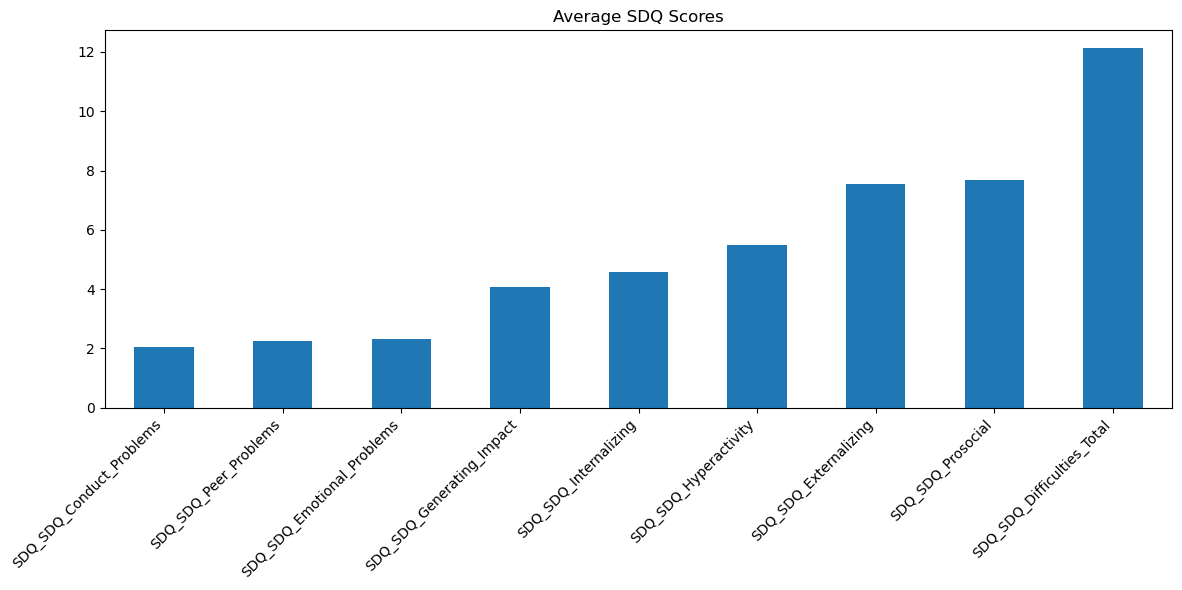

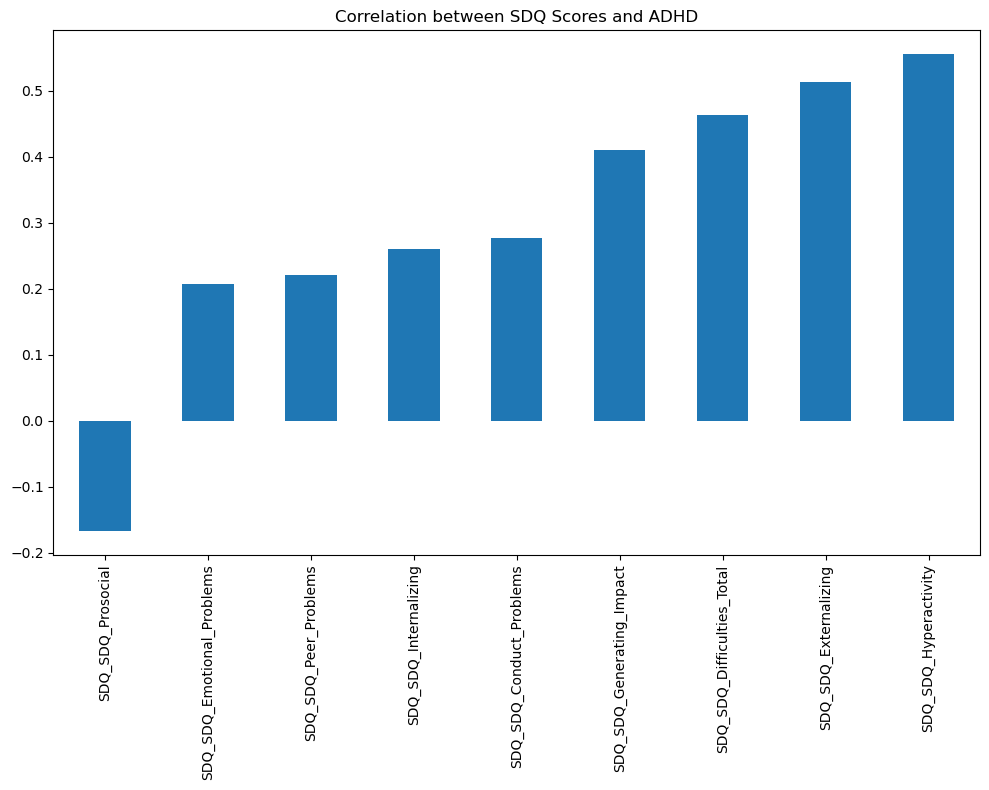

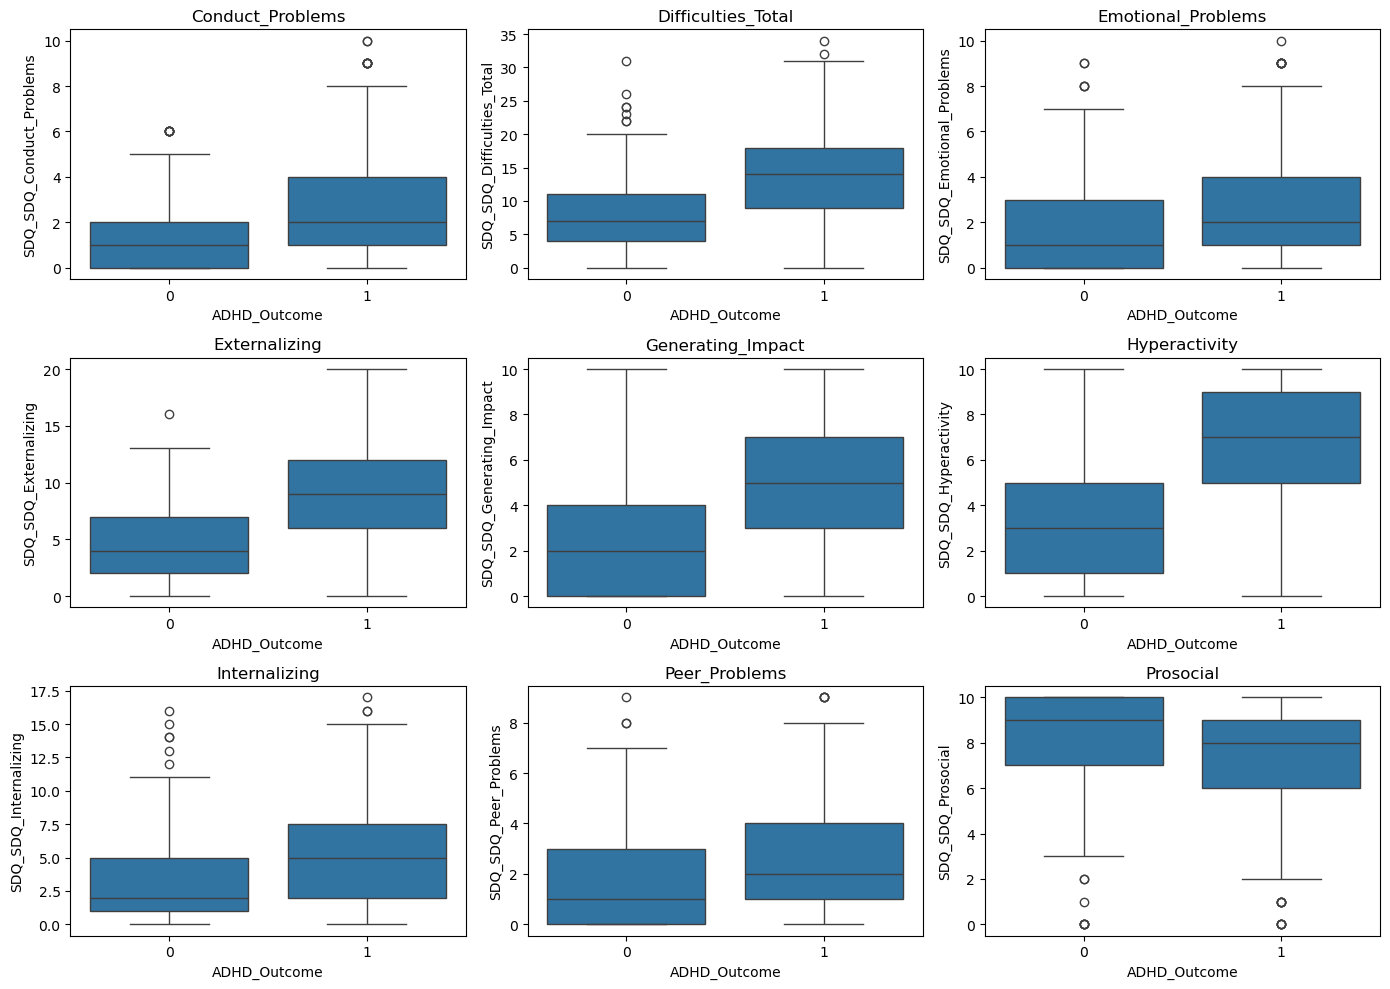

In [42]:

sdq_vars = [col for col in train.columns if col.startswith('SDQ')]

# 1. Distribution overview
fig, ax = plt.subplots(figsize=(12, 6))
train[sdq_vars].mean().sort_values().plot(kind='bar', ax=ax)
plt.title('Average SDQ Scores')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("Visualizations/Distribution_Overview.jpeg")
plt.show()

# 2. Correlation with ADHD
plt.figure(figsize=(10, 8))
sdq_adhd_corr = train[sdq_vars + ['ADHD_Outcome']].corr()['ADHD_Outcome'].drop('ADHD_Outcome').sort_values()
sdq_adhd_corr.plot(kind='bar')
plt.title('Correlation between SDQ Scores and ADHD')
plt.tight_layout()
plt.savefig("Visualizations/Correlations_ADHD.jpeg")
plt.show()

# 3. Box plots by ADHD diagnosis
plt.figure(figsize=(14, 10))
for i, var in enumerate(sdq_vars):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='ADHD_Outcome', y=var, data=train)
    plt.title(var.split('SDQ_SDQ_')[1])
plt.tight_layout()
plt.savefig("Visualizations/Boxplots_ADHD.jpeg")
plt.show()

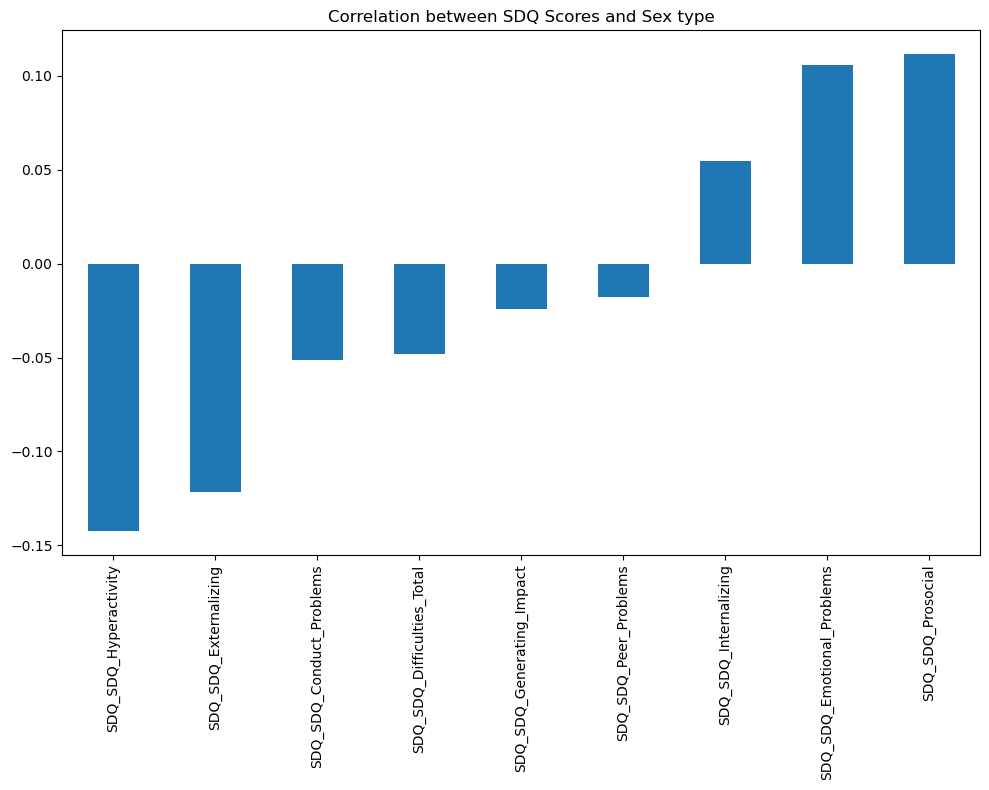

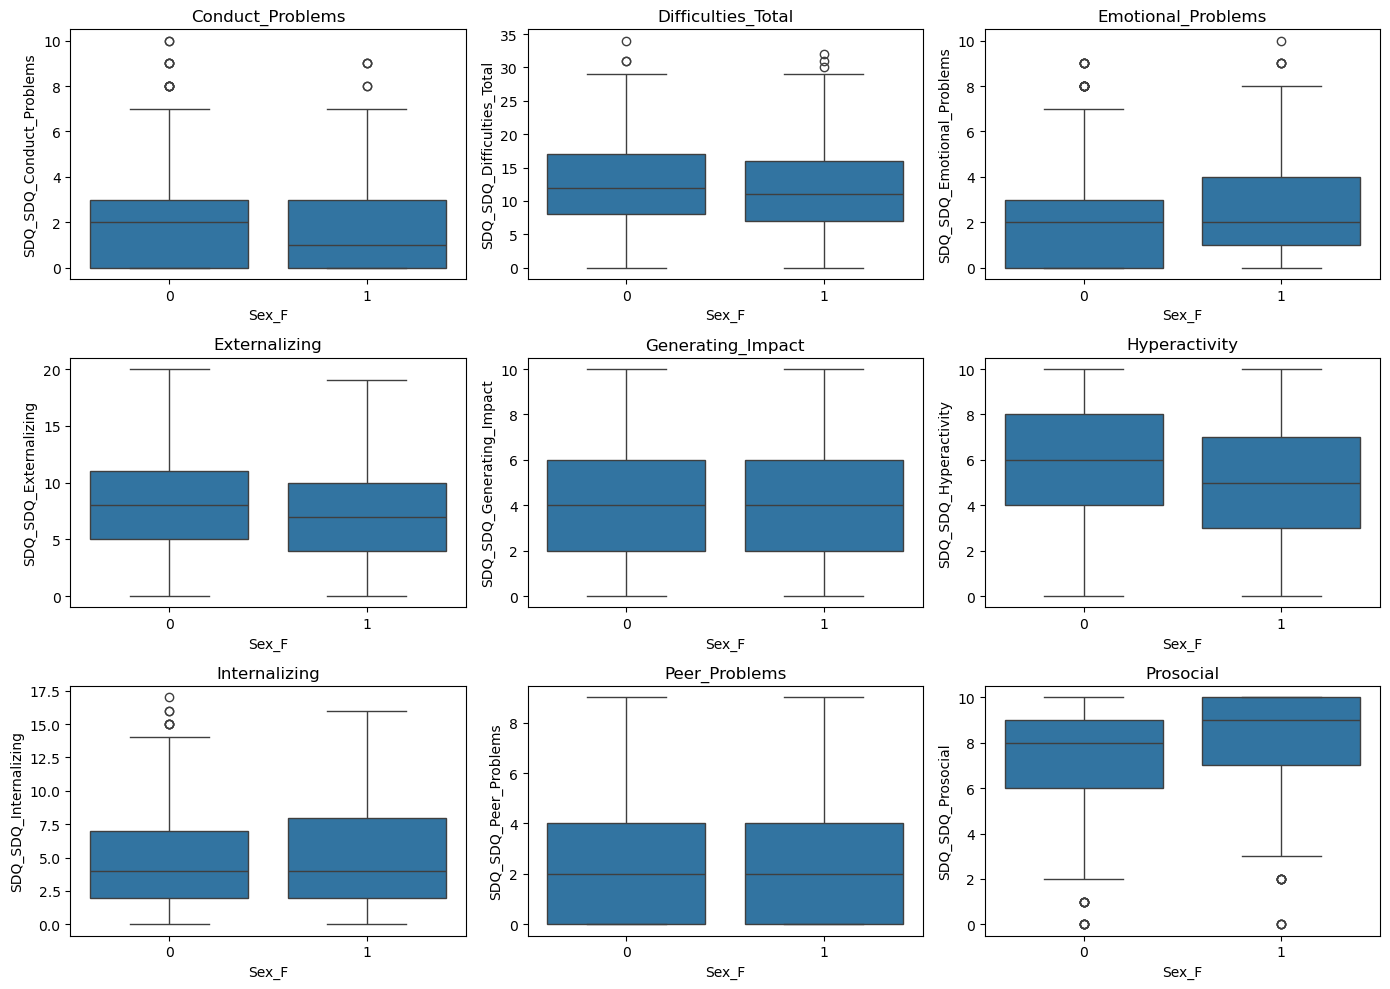

In [51]:

sdq_vars = [col for col in train.columns if col.startswith('SDQ')]

# 1. Correlation with Sex
plt.figure(figsize=(10, 8))
sdq_adhd_corr = train[sdq_vars + ['Sex_F']].corr()['Sex_F'].drop('Sex_F').sort_values()
sdq_adhd_corr.plot(kind='bar')
plt.title('Correlation between SDQ Scores and Sex type')
plt.tight_layout()
plt.savefig("Visualizations/Correlations_Sex.jpeg")
plt.show()

# 2. Box plots by Sex 
plt.figure(figsize=(14, 10))
for i, var in enumerate(sdq_vars):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='Sex_F', y=var, data=train)
    plt.title(var.split('SDQ_SDQ_')[1])
plt.tight_layout()
plt.savefig("Visualizations/Boxplots_Sex.jpeg")
plt.show()

## Visualization 2 : Parenting Questionnaire

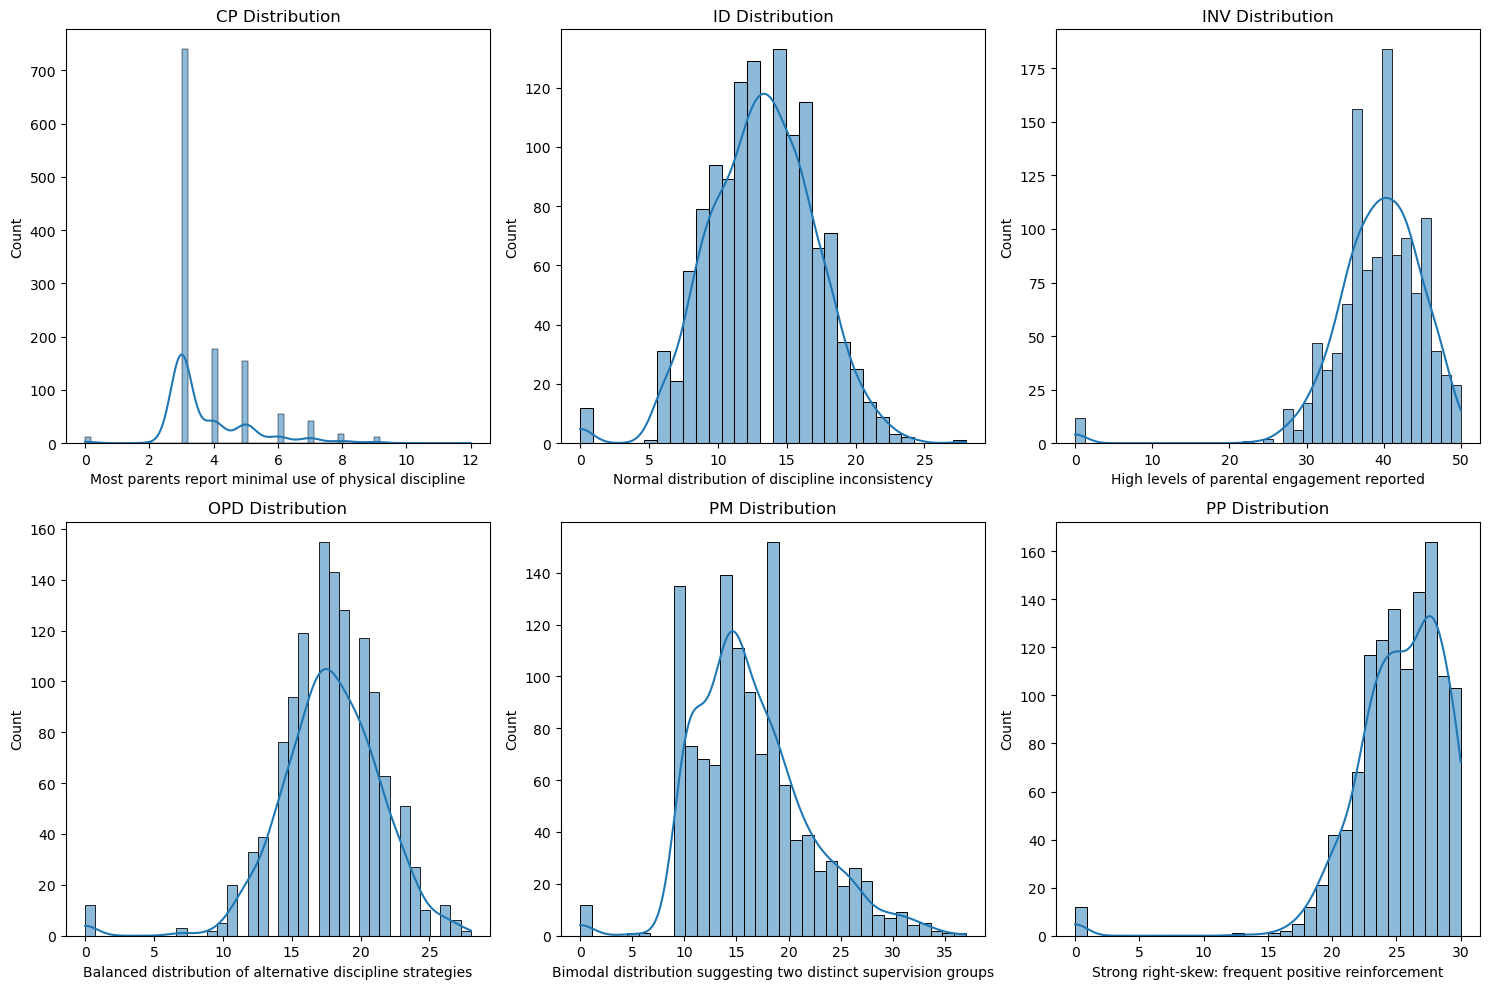

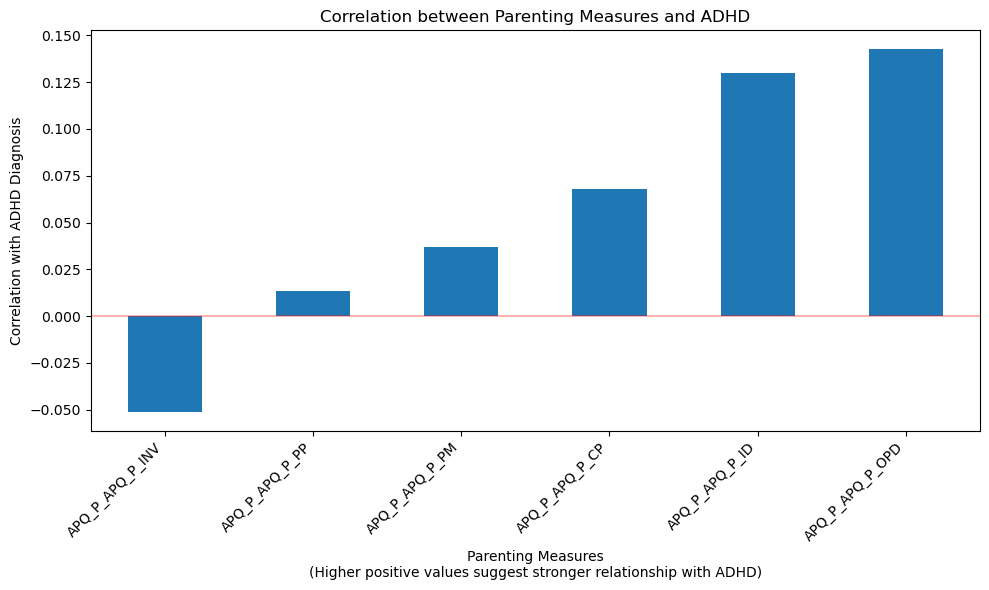

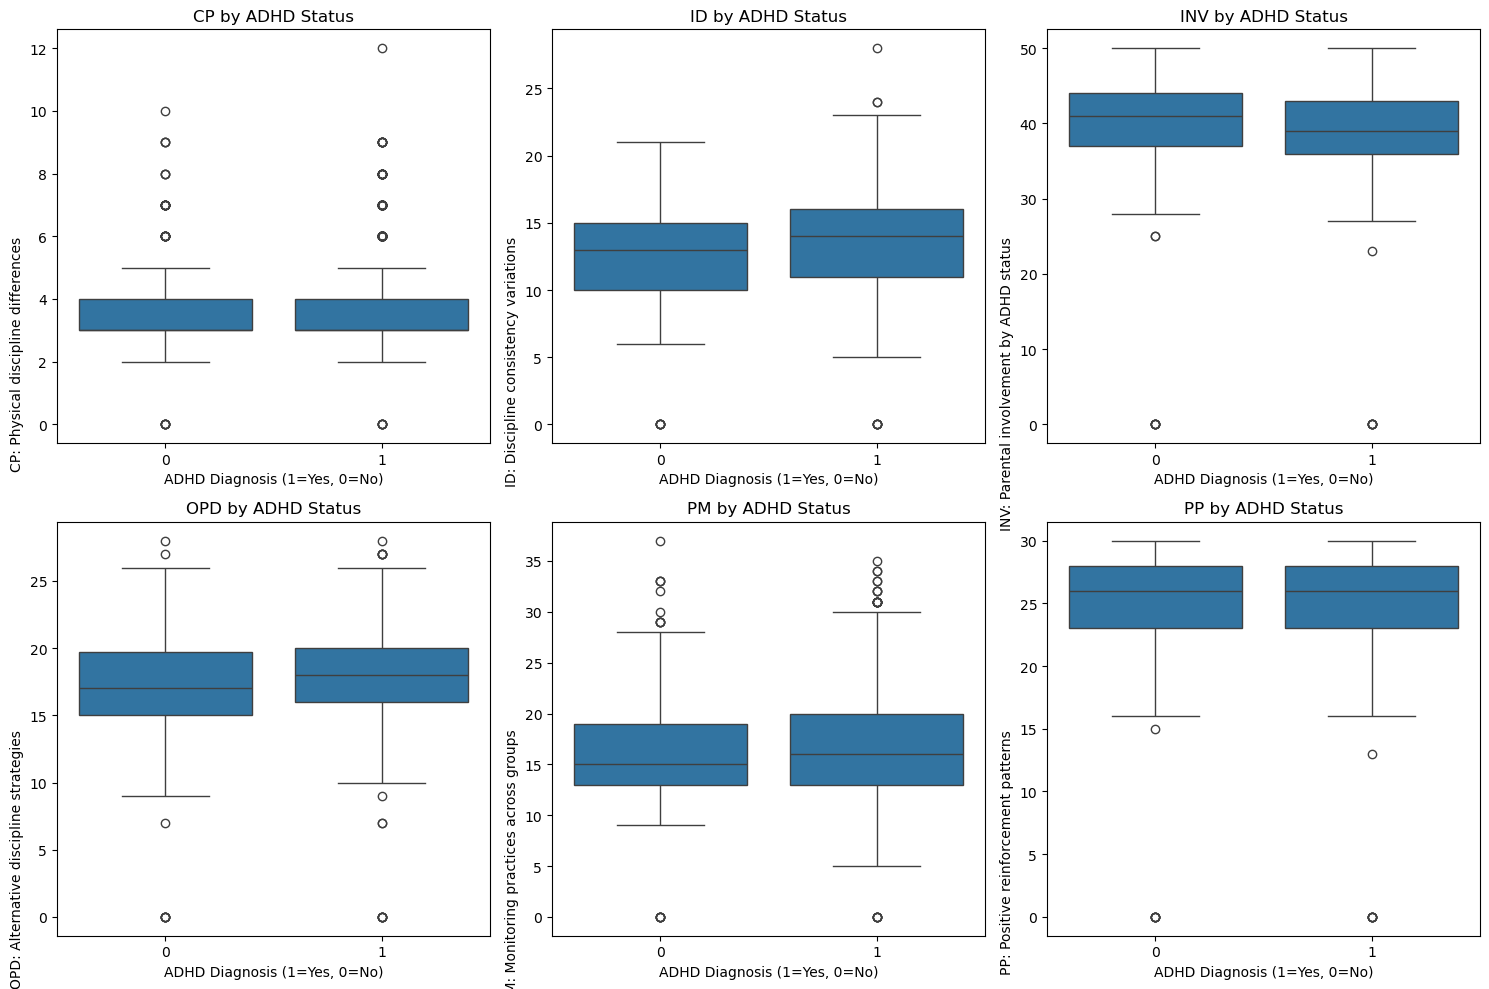

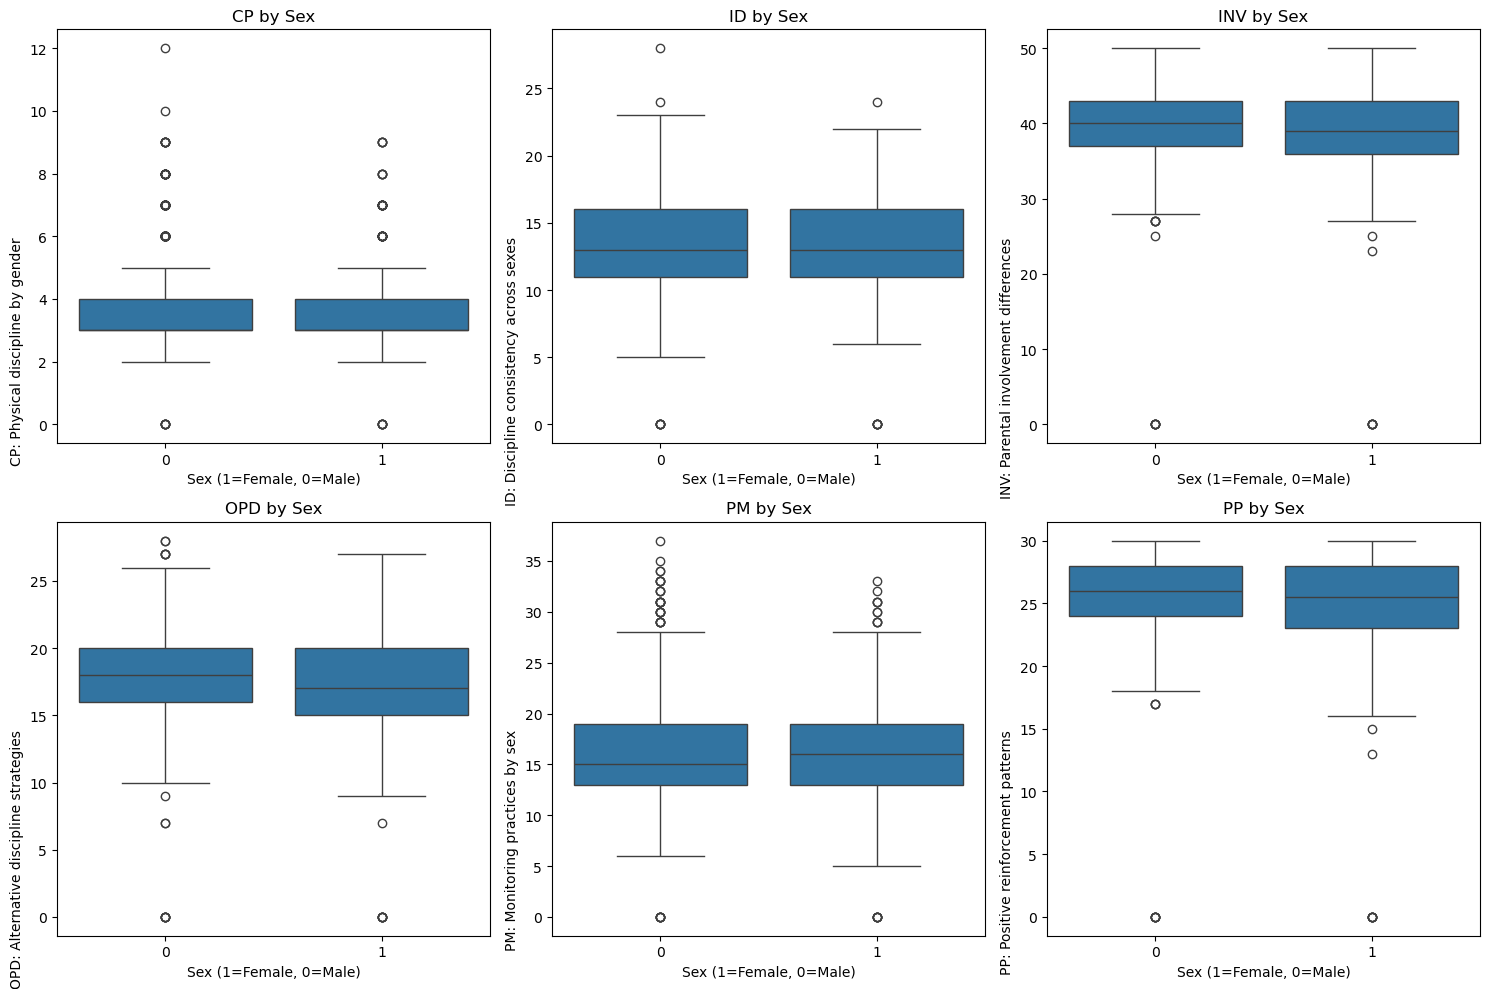

'\nDetailed Observations:\n- Corporal Punishment (CP): Most parents report minimal use of physical discipline, with scores heavily concentrated at the low end.\n- Inconsistent Discipline (ID): Parents show a normal distribution of inconsistency in rule enforcement, with most showing moderate levels.\n- Involvement (INV): Parents typically report high levels of engagement with their children, with most scores in the upper range.\n- Other Discipline Practices (OPD): Alternative discipline strategies show a balanced distribution with most parents using a moderate amount.\n- Poor Monitoring (PM): The bimodal distribution suggests two distinct groups of parents regarding supervision practices.\n- Positive Parenting (PP): The strong right-skew indicates that most parents report frequent use of praise and positive reinforcement.\n\nCorrelation Insights:\n- Higher levels of parental engagement (spending time with children, participating in their activities, talking about their day, etc.) is as

In [62]:
# APQ Features EDA
apq_vars = [col for col in train.columns if 'APQ_P_APQ_P' in col]

# 1. Distribution of APQ scores
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, var in enumerate(apq_vars):
    sns.histplot(train[var], kde=True, ax=axes[i])
    var_name = var.replace('APQ_P_APQ_P_', '')
    axes[i].set_title(f'{var_name} Distribution')
    
# Add descriptive labels for distribution charts
labels = [
    "Most parents report minimal use of physical discipline",
    "Normal distribution of discipline inconsistency",
    "High levels of parental engagement reported",
    "Balanced distribution of alternative discipline strategies",
    "Bimodal distribution suggesting two distinct supervision groups",
    "Strong right-skew: frequent positive reinforcement"
]

for i, label in enumerate(labels):
    axes[i].set_xlabel(label, wrap=True)
    
plt.tight_layout()
plt.savefig("Visualizations/Distributions_APQ.jpeg")
plt.show()

# 2. Correlation between parenting measures and ADHD
corr_apq_adhd = train[apq_vars + ['ADHD_Outcome']].corr()['ADHD_Outcome'].drop('ADHD_Outcome')
plt.figure(figsize=(10, 6))
corr_plot = corr_apq_adhd.sort_values().plot(kind='bar')
plt.title('Correlation between Parenting Measures and ADHD')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation with ADHD Diagnosis')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xlabel('Parenting Measures\n(Higher positive values suggest stronger relationship with ADHD)', wrap=True)
plt.tight_layout()
plt.savefig("Visualizations/Correlation_Parenting_ADHD.jpeg")
plt.show()

# 3. Compare distributions by ADHD diagnosis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, var in enumerate(apq_vars):
    sns.boxplot(x='ADHD_Outcome', y=var, data=train, ax=axes[i])
    var_name = var.replace('APQ_P_APQ_P_', '')
    axes[i].set_title(f'{var_name} by ADHD Status')
    axes[i].set_xlabel('ADHD Diagnosis (1=Yes, 0=No)')
    
# Add descriptive labels for ADHD status charts
labels = [
    "CP: Physical discipline differences",
    "ID: Discipline consistency variations",
    "INV: Parental involvement by ADHD status",
    "OPD: Alternative discipline strategies",
    "PM: Monitoring practices across groups",
    "PP: Positive reinforcement patterns"
]

for i, label in enumerate(labels):
    axes[i].set_ylabel(label, rotation=90, ha='right')
    
plt.tight_layout()
plt.savefig("Visualizations/Distributions_ADHD.jpeg")
plt.show()

# 4. Relationship between parenting styles and sex
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, var in enumerate(apq_vars):
    sns.boxplot(x='Sex_F', y=var, data=train, ax=axes[i])
    var_name = var.replace('APQ_P_APQ_P_', '')
    axes[i].set_title(f'{var_name} by Sex')
    axes[i].set_xlabel('Sex (1=Female, 0=Male)')
    
# Add descriptive labels for sex comparison charts
labels = [
    "CP: Physical discipline by gender",
    "ID: Discipline consistency across sexes",
    "INV: Parental involvement differences",
    "OPD: Alternative discipline strategies",
    "PM: Monitoring practices by sex",
    "PP: Positive reinforcement patterns"
]

for i, label in enumerate(labels):
    axes[i].set_ylabel(label, rotation=90, ha='right')
    
plt.tight_layout()
plt.savefig("Visualizations/Parenting_Styles_Sex.jpeg")
plt.show()

"""
Detailed Observations:
- Corporal Punishment (CP): Most parents report minimal use of physical discipline, with scores heavily concentrated at the low end.
- Inconsistent Discipline (ID): Parents show a normal distribution of inconsistency in rule enforcement, with most showing moderate levels.
- Involvement (INV): Parents typically report high levels of engagement with their children, with most scores in the upper range.
- Other Discipline Practices (OPD): Alternative discipline strategies show a balanced distribution with most parents using a moderate amount.
- Poor Monitoring (PM): The bimodal distribution suggests two distinct groups of parents regarding supervision practices.
- Positive Parenting (PP): The strong right-skew indicates that most parents report frequent use of praise and positive reinforcement.

Correlation Insights:
- Higher levels of parental engagement (spending time with children, participating in their activities, talking about their day, etc.) is associated with somewhat lower rates of ADHD diagnosis.
"""


- **Corporal Punishment (CP)**: Most parents report minimal use of physical discipline, with scores heavily concentrated at the low end.

- **Inconsistent Discipline (ID)**: Parents show a normal distribution of inconsistency in rule enforcement, with most showing moderate levels.

- **Involvement (INV)**: Parents typically report high levels of engagement with their children, with most scores in the upper range.

- **Other Discipline Practices (OPD)**: Alternative discipline strategies show a balanced distribution with most parents using a moderate amount.

- **Poor Monitoring (PM)**: The bimodal distribution suggests two distinct groups of parents regarding supervision practices.

- **Positive Parenting (PP)**: The strong right-skew indicates that most parents report frequent use of praise and positive reinforcement.

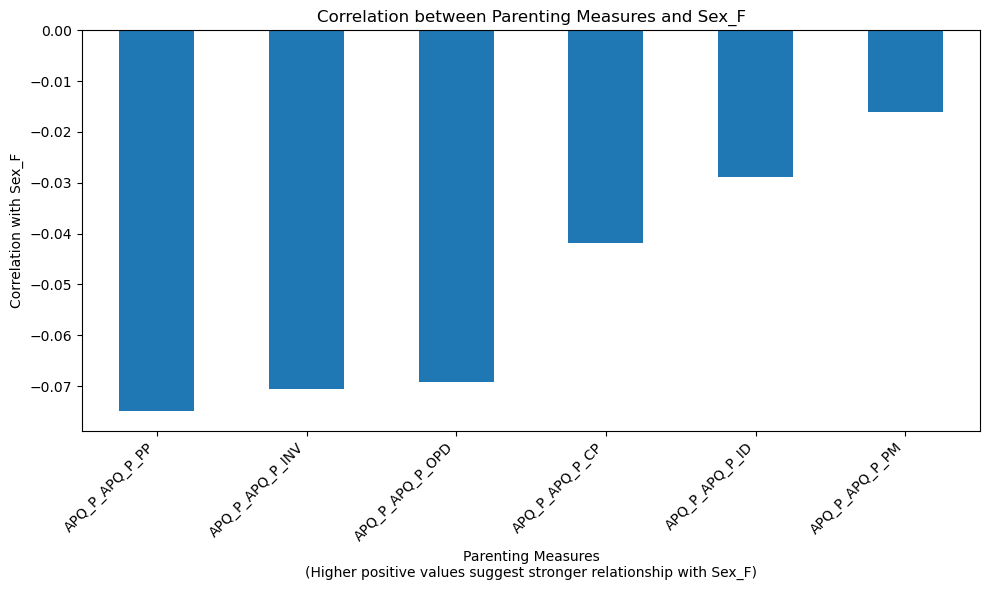

'\nDetailed Observations:\n- Corporal Punishment (CP): Most parents report minimal use of physical discipline, with scores heavily concentrated at the low end.\n- Inconsistent Discipline (ID): Parents show a normal distribution of inconsistency in rule enforcement, with most showing moderate levels.\n- Involvement (INV): Parents typically report high levels of engagement with their children, with most scores in the upper range.\n- Other Discipline Practices (OPD): Alternative discipline strategies show a balanced distribution with most parents using a moderate amount.\n- Poor Monitoring (PM): The bimodal distribution suggests two distinct groups of parents regarding supervision practices.\n- Positive Parenting (PP): The strong right-skew indicates that most parents report frequent use of praise and positive reinforcement.\n\nCorrelation Insights:\n- Higher levels of parental engagement (spending time with children, participating in their activities, talking about their day, etc.) is as

In [47]:
# APQ Features EDA
apq_vars = [col for col in train.columns if 'APQ_P_APQ_P' in col]

# 2. Correlation between parenting measures and ADHD
corr_apq_adhd = train[apq_vars + ['Sex_F']].corr()['Sex_F'].drop('Sex_F')
plt.figure(figsize=(10, 6))
corr_plot = corr_apq_adhd.sort_values().plot(kind='bar')
plt.title('Correlation between Parenting Measures and Sex_F')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation with Sex_F')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xlabel('Parenting Measures\n(Higher positive values suggest stronger relationship with Sex_F)', wrap=True)
plt.tight_layout()
plt.show()

"""
Detailed Observations:
- Corporal Punishment (CP): Most parents report minimal use of physical discipline, with scores heavily concentrated at the low end.
- Inconsistent Discipline (ID): Parents show a normal distribution of inconsistency in rule enforcement, with most showing moderate levels.
- Involvement (INV): Parents typically report high levels of engagement with their children, with most scores in the upper range.
- Other Discipline Practices (OPD): Alternative discipline strategies show a balanced distribution with most parents using a moderate amount.
- Poor Monitoring (PM): The bimodal distribution suggests two distinct groups of parents regarding supervision practices.
- Positive Parenting (PP): The strong right-skew indicates that most parents report frequent use of praise and positive reinforcement.

Correlation Insights:
- Higher levels of parental engagement (spending time with children, participating in their activities, talking about their day, etc.) is associated with somewhat lower rates of ADHD diagnosis.
"""

## Visualization 3 : Clinical Measures

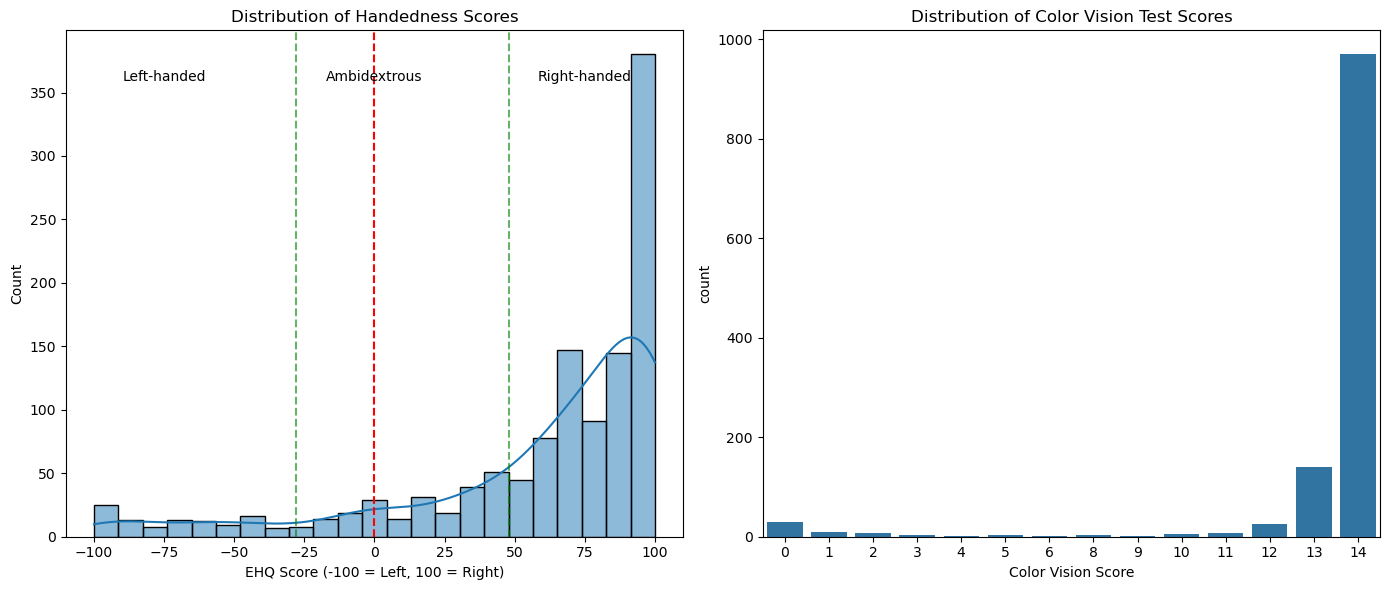

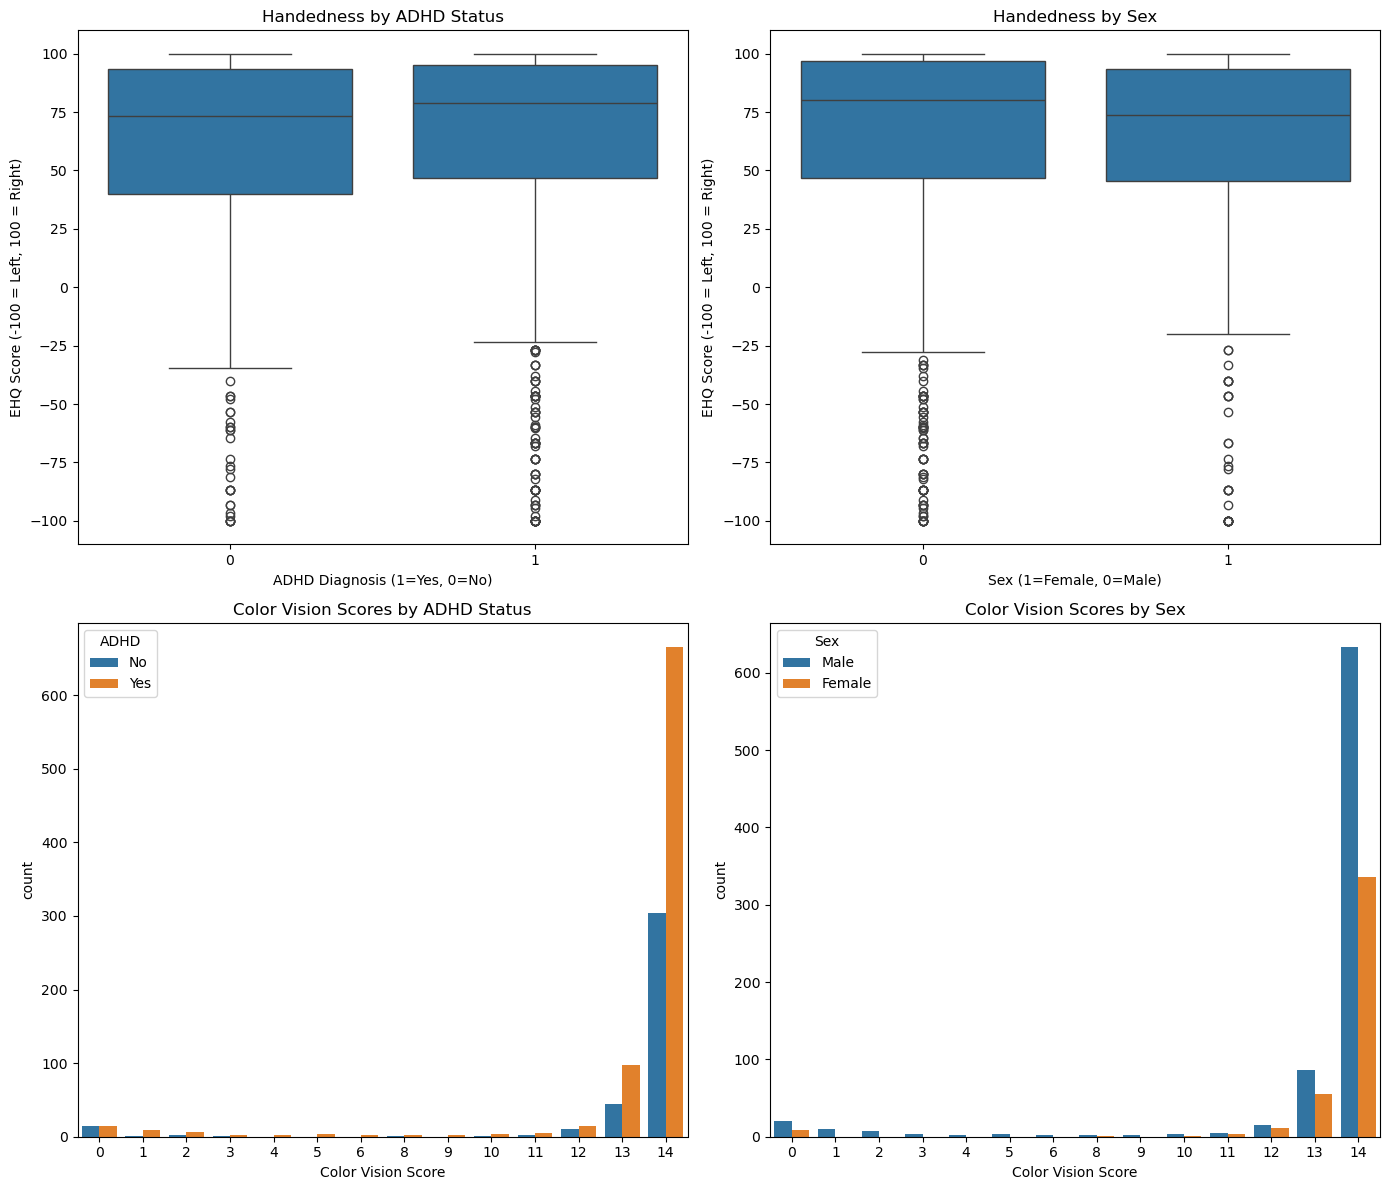

Statistical Tests for Clinical Measures:
Handedness difference by ADHD: t-stat=0.599, p-value=0.549
Handedness difference by Sex: t-stat=0.015, p-value=0.988
Color vision association with ADHD: chi2=12.625, p-value=0.477
Color vision association with Sex: chi2=19.523, p-value=0.108


In [34]:
# Clinical Measures EDA (Handedness and Color Vision)
clinical_vars = ['EHQ_EHQ_Total', 'ColorVision_CV_Score']

# 1. Distribution of clinical measures
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Handedness distribution
sns.histplot(train['EHQ_EHQ_Total'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Handedness Scores')
axes[0].set_xlabel('EHQ Score (-100 = Left, 100 = Right)')
axes[0].axvline(x=0, color='r', linestyle='--')

# Add vertical lines for handedness categories
axes[0].axvline(x=-28, color='g', linestyle='--', alpha=0.6)
axes[0].axvline(x=48, color='g', linestyle='--', alpha=0.6)
# Add text for handedness regions
axes[0].text(-75, axes[0].get_ylim()[1]*0.9, 'Left-handed', ha='center')
axes[0].text(0, axes[0].get_ylim()[1]*0.9, 'Ambidextrous', ha='center')
axes[0].text(75, axes[0].get_ylim()[1]*0.9, 'Right-handed', ha='center')

# Color vision distribution
sns.countplot(x=train['ColorVision_CV_Score'], ax=axes[1])
axes[1].set_title('Distribution of Color Vision Test Scores')
axes[1].set_xlabel('Color Vision Score')

plt.tight_layout()
plt.show()

# 2. Relationship with ADHD and Sex
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Handedness by ADHD
sns.boxplot(x='ADHD_Outcome', y='EHQ_EHQ_Total', data=train, ax=axes[0, 0])
axes[0, 0].set_title('Handedness by ADHD Status')
axes[0, 0].set_xlabel('ADHD Diagnosis (1=Yes, 0=No)')
axes[0, 0].set_ylabel('EHQ Score (-100 = Left, 100 = Right)')

# Handedness by Sex
sns.boxplot(x='Sex_F', y='EHQ_EHQ_Total', data=train, ax=axes[0, 1])
axes[0, 1].set_title('Handedness by Sex')
axes[0, 1].set_xlabel('Sex (1=Female, 0=Male)')
axes[0, 1].set_ylabel('EHQ Score (-100 = Left, 100 = Right)')

# Color vision by ADHD
sns.countplot(x='ColorVision_CV_Score', hue='ADHD_Outcome', data=train, ax=axes[1, 0])
axes[1, 0].set_title('Color Vision Scores by ADHD Status')
axes[1, 0].set_xlabel('Color Vision Score')
axes[1, 0].legend(title='ADHD', labels=['No', 'Yes'])

# Color vision by Sex
sns.countplot(x='ColorVision_CV_Score', hue='Sex_F', data=train, ax=axes[1, 1])
axes[1, 1].set_title('Color Vision Scores by Sex')
axes[1, 1].set_xlabel('Color Vision Score')
axes[1, 1].legend(title='Sex', labels=['Male', 'Female'])

plt.tight_layout()
plt.show()

# 3. Statistical tests for differences
print("Statistical Tests for Clinical Measures:")

# Handedness by ADHD
from scipy.stats import ttest_ind
adhd_positive = train.loc[train['ADHD_Outcome'] == 1, 'EHQ_EHQ_Total']
adhd_negative = train.loc[train['ADHD_Outcome'] == 0, 'EHQ_EHQ_Total']
t_stat, p_val = ttest_ind(adhd_positive, adhd_negative)
print(f"Handedness difference by ADHD: t-stat={t_stat:.3f}, p-value={p_val:.3f}")

# Handedness by Sex
male = train.loc[train['Sex_F'] == 0, 'EHQ_EHQ_Total']
female = train.loc[train['Sex_F'] == 1, 'EHQ_EHQ_Total']
t_stat, p_val = ttest_ind(male, female)
print(f"Handedness difference by Sex: t-stat={t_stat:.3f}, p-value={p_val:.3f}")

# Color vision by ADHD
from scipy.stats import chi2_contingency
color_adhd_contingency = pd.crosstab(train['ColorVision_CV_Score'], train['ADHD_Outcome'])
chi2, p_val, dof, expected = chi2_contingency(color_adhd_contingency)
print(f"Color vision association with ADHD: chi2={chi2:.3f}, p-value={p_val:.3f}")

# Color vision by Sex
color_sex_contingency = pd.crosstab(train['ColorVision_CV_Score'], train['Sex_F'])
chi2, p_val, dof, expected = chi2_contingency(color_sex_contingency)
print(f"Color vision association with Sex: chi2={chi2:.3f}, p-value={p_val:.3f}")

## Visualization 4: DEMOGRAPHIC MEASURES

- Study enrollment details
- Testing locations
- Ethnic and racial background
- Parental education level


# Study Site Distribution Analysis

## Site Breakdown

| Site Code | Location | Participant Count | Color | Notes |
|-----------|----------|------------------|-------|-------|
| 1 | Staten Island | 600-650 | Blue | Primary study site |
| 2 | MRV | Very few | Orange | Minimal representation |
| 3 | Midtown | 400-450 | Green | Second most common site |
| 4 | Harlem | 100-150 | Red | Smaller participant group |

## Key Observations

- **Staten Island** dominates the study site distribution
- **Midtown** serves as a secondary research location
- **Harlem** contributes a smaller sample
- **MRV** has minimal participant representation

## Potential Factors Influencing Site Distribution

1. Recruitment capabilities
2. Population density
3. Access to research facilities
4. Study-specific recruitment strategies

## Significance

The variation in sample sizes across sites may impact:
- Statistical power
- Generalizability of research findings
- Potential site-specific biases



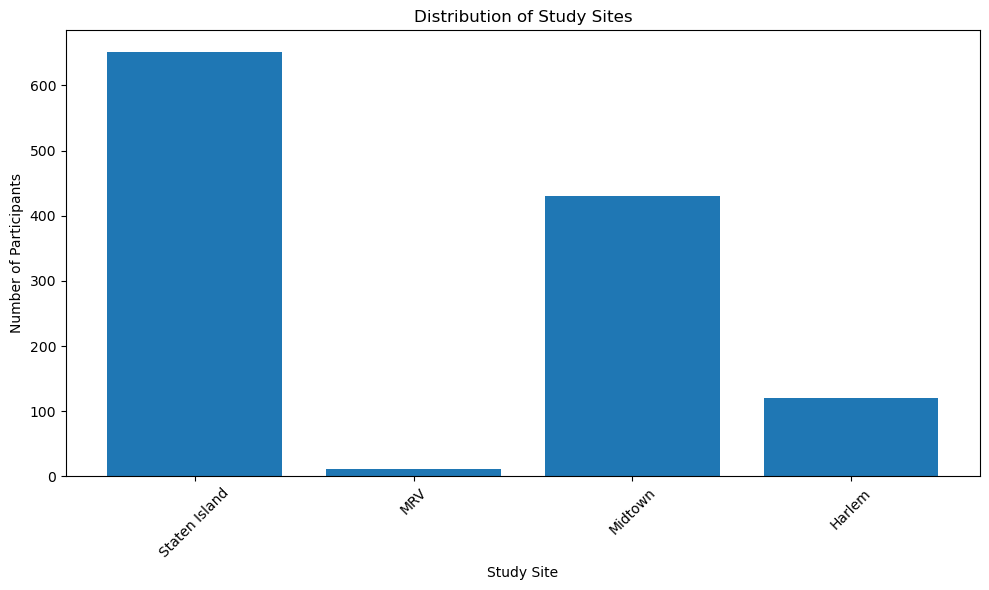

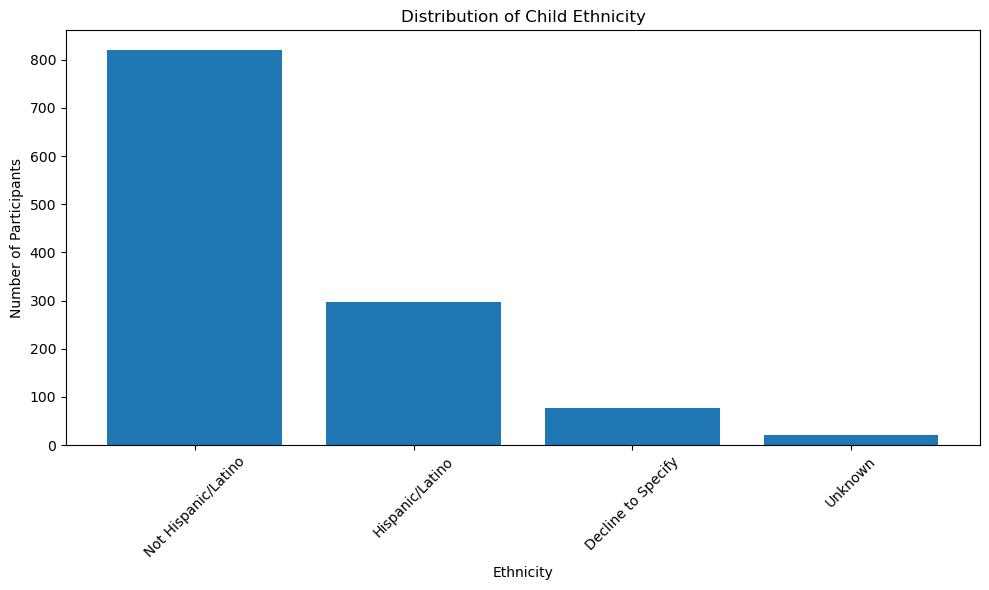

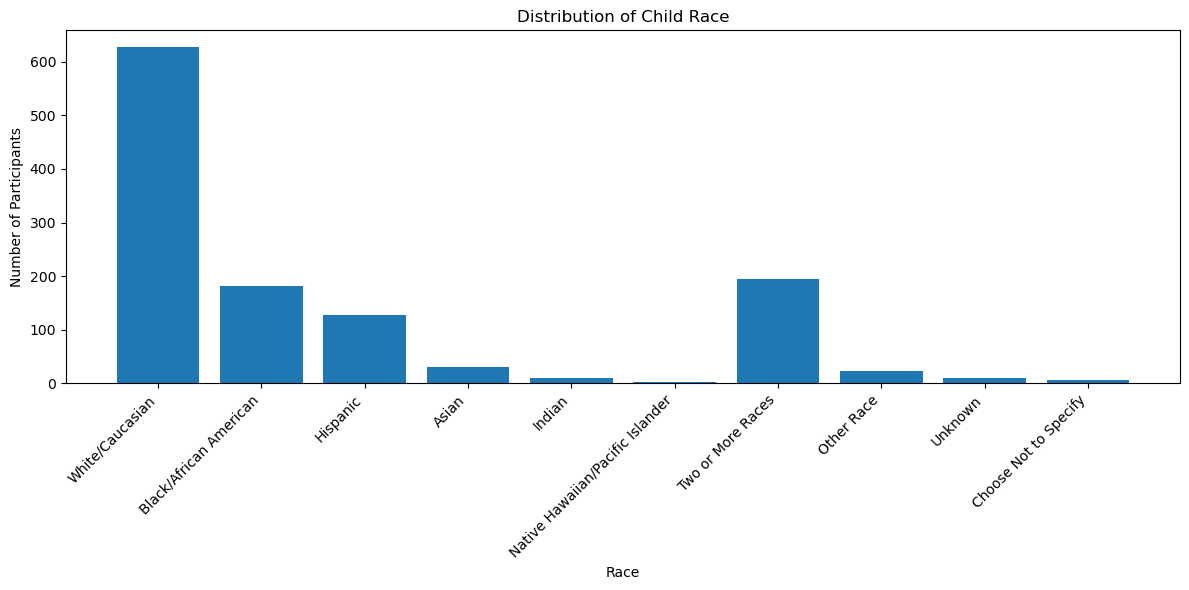

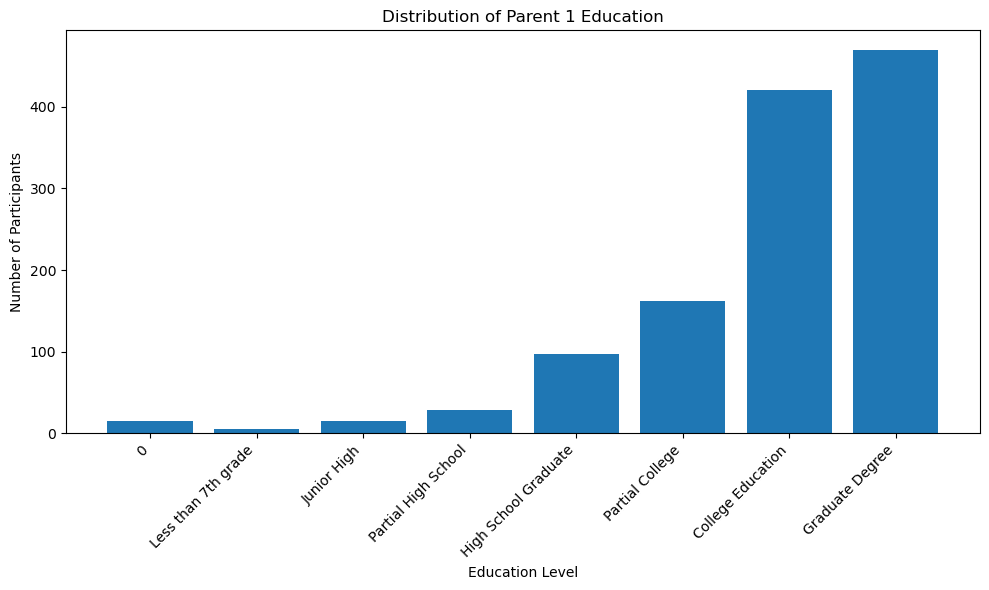

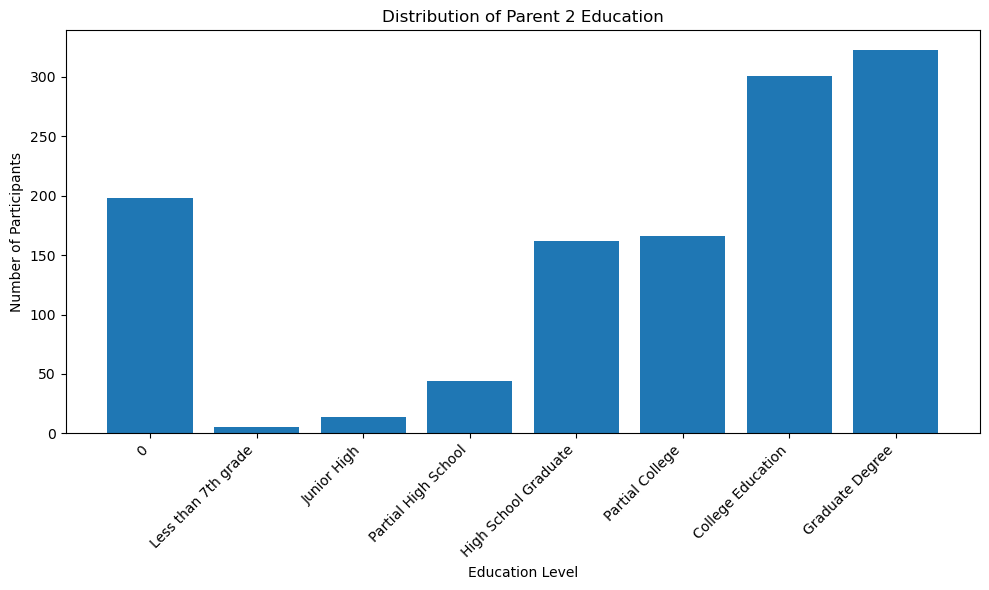

Study Site Counts:
Basic_Demos_Study_Site
1    652
2     11
3    430
4    120
Name: count, dtype: int64

Ethnicity Counts:
PreInt_Demos_Fam_Child_Ethnicity
0.0    820
1.0    296
2.0     77
3.0     20
Name: count, dtype: int64

Race Counts:
PreInt_Demos_Fam_Child_Race
0     627
1     181
2     128
3      30
4      10
7       2
8     195
9      23
10     11
11      6
Name: count, dtype: int64

Parent 1 Education Counts:
Barratt_Barratt_P2_Edu
0     198
3       5
6      14
9      44
12    162
15    166
18    301
21    323
Name: count, dtype: int64


In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Study Site Distribution
plt.figure(figsize=(10, 6))
site_labels = ['Staten Island', 'MRV', 'Midtown', 'Harlem']
site_counts = train['Basic_Demos_Study_Site'].value_counts().sort_index()
plt.bar(site_labels, site_counts)
plt.title('Distribution of Study Sites')
plt.xlabel('Study Site')
plt.ylabel('Number of Participants')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Ethnicity Distribution
plt.figure(figsize=(10, 6))
ethnicity_counts = train['PreInt_Demos_Fam_Child_Ethnicity'].value_counts().sort_index()
ethnicity_labels = {
    0: 'Not Hispanic/Latino', 
    1: 'Hispanic/Latino', 
    2: 'Decline to Specify', 
    3: 'Unknown'
}

# Use the actual index values and corresponding labels
plt.bar(
    [ethnicity_labels.get(x, str(x)) for x in ethnicity_counts.index], 
    ethnicity_counts
)
plt.title('Distribution of Child Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Number of Participants')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Race Distribution
# Race Distribution
plt.figure(figsize=(12, 6))
race_labels_dict = {
    0: 'White/Caucasian', 
    1: 'Black/African American', 
    2: 'Hispanic', 
    3: 'Asian', 
    4: 'Indian', 
    5: 'Native American Indian', 
    6: 'American Indian/Alaskan Native', 
    7: 'Native Hawaiian/Pacific Islander', 
    8: 'Two or More Races', 
    9: 'Other Race', 
    10: 'Unknown', 
    11: 'Choose Not to Specify'
}

race_counts = train['PreInt_Demos_Fam_Child_Race'].value_counts().sort_index()

# Use actual index values and corresponding labels
plt.bar(
    [race_labels_dict.get(x, str(x)) for x in race_counts.index], 
    race_counts
)
plt.title('Distribution of Child Race')
plt.xlabel('Race')
plt.ylabel('Number of Participants')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Parent 1 Education Distribution
# Parent 1 Education Distribution
plt.figure(figsize=(10, 6))
edu_labels_dict = {
    3: 'Less than 7th grade',
    6: 'Junior High',
    9: 'Partial High School',
    12: 'High School Graduate',
    15: 'Partial College',
    18: 'College Education',
    21: 'Graduate Degree'
}

edu_counts = train['Barratt_Barratt_P1_Edu'].value_counts().sort_index()

# Use actual index values and corresponding labels
plt.bar(
    [edu_labels_dict.get(x, str(x)) for x in edu_counts.index], 
    edu_counts
)
plt.title('Distribution of Parent 1 Education')
plt.xlabel('Education Level')
plt.ylabel('Number of Participants')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Parent 2 Education Distribution
# Parent 2 Education Distribution
plt.figure(figsize=(10, 6))
edu_labels_dict = {
    3: 'Less than 7th grade',
    6: 'Junior High',
    9: 'Partial High School',
    12: 'High School Graduate',
    15: 'Partial College',
    18: 'College Education',
    21: 'Graduate Degree'
}

edu_counts = train['Barratt_Barratt_P2_Edu'].value_counts().sort_index()

# Use actual index values and corresponding labels
plt.bar(
    [edu_labels_dict.get(x, str(x)) for x in edu_counts.index], 
    edu_counts
)
plt.title('Distribution of Parent 2 Education')
plt.xlabel('Education Level')
plt.ylabel('Number of Participants')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



# Optional: Print out the exact counts for reference
print("Study Site Counts:")
print(site_counts)
print("\nEthnicity Counts:")
print(ethnicity_counts)
print("\nRace Counts:")
print(race_counts)
print("\nParent 1 Education Counts:")
print(edu_counts)

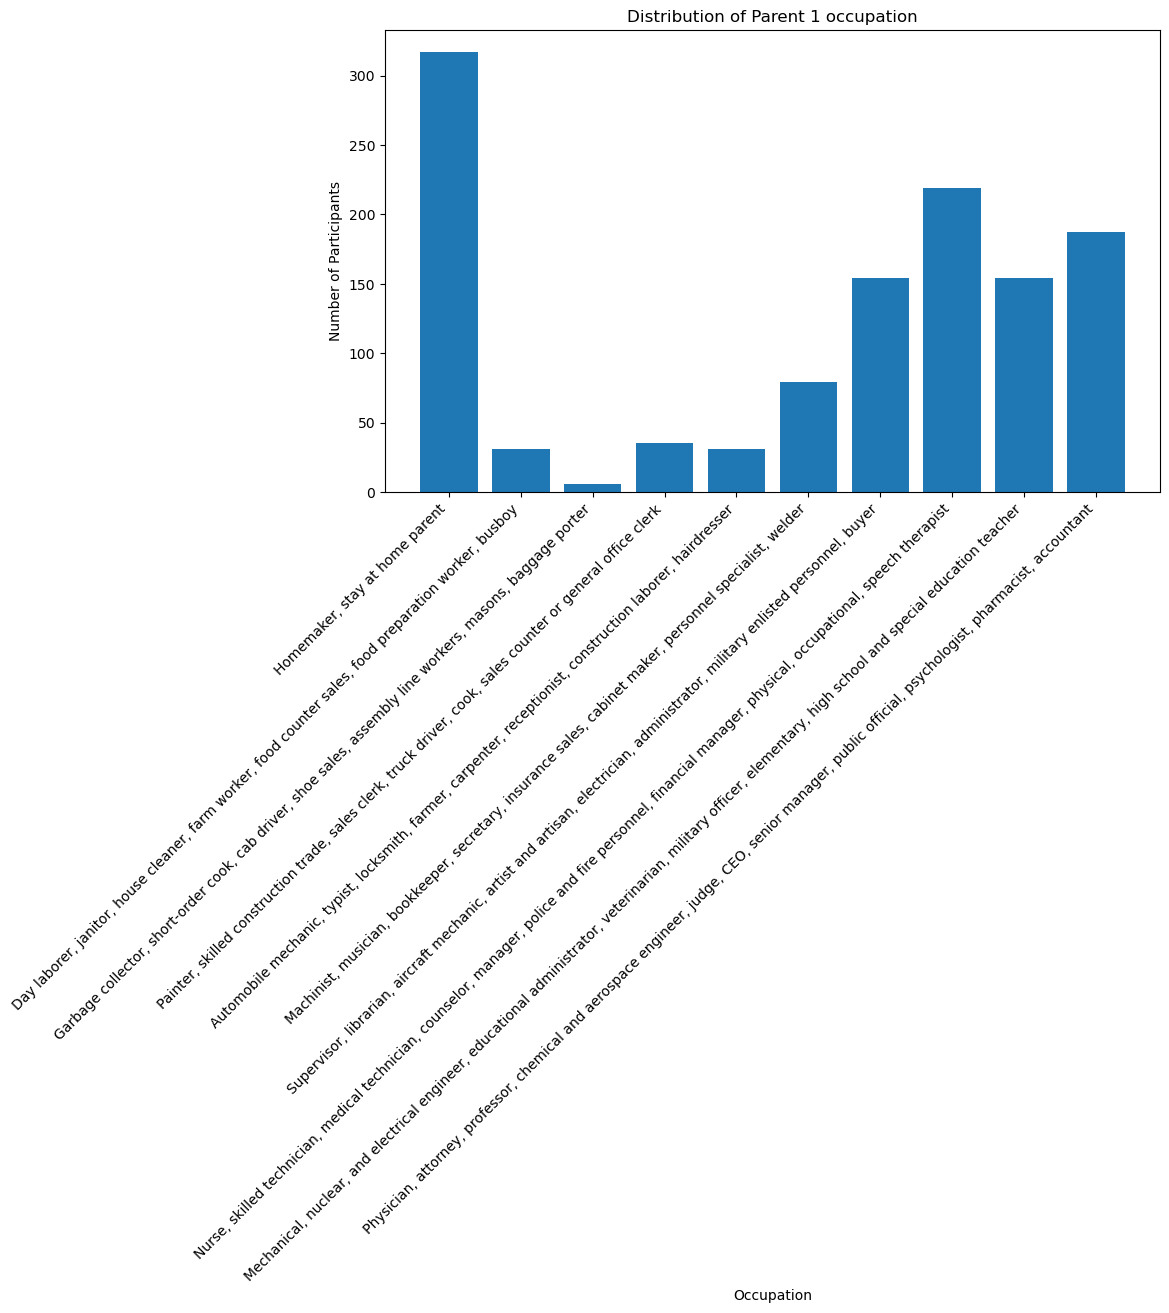

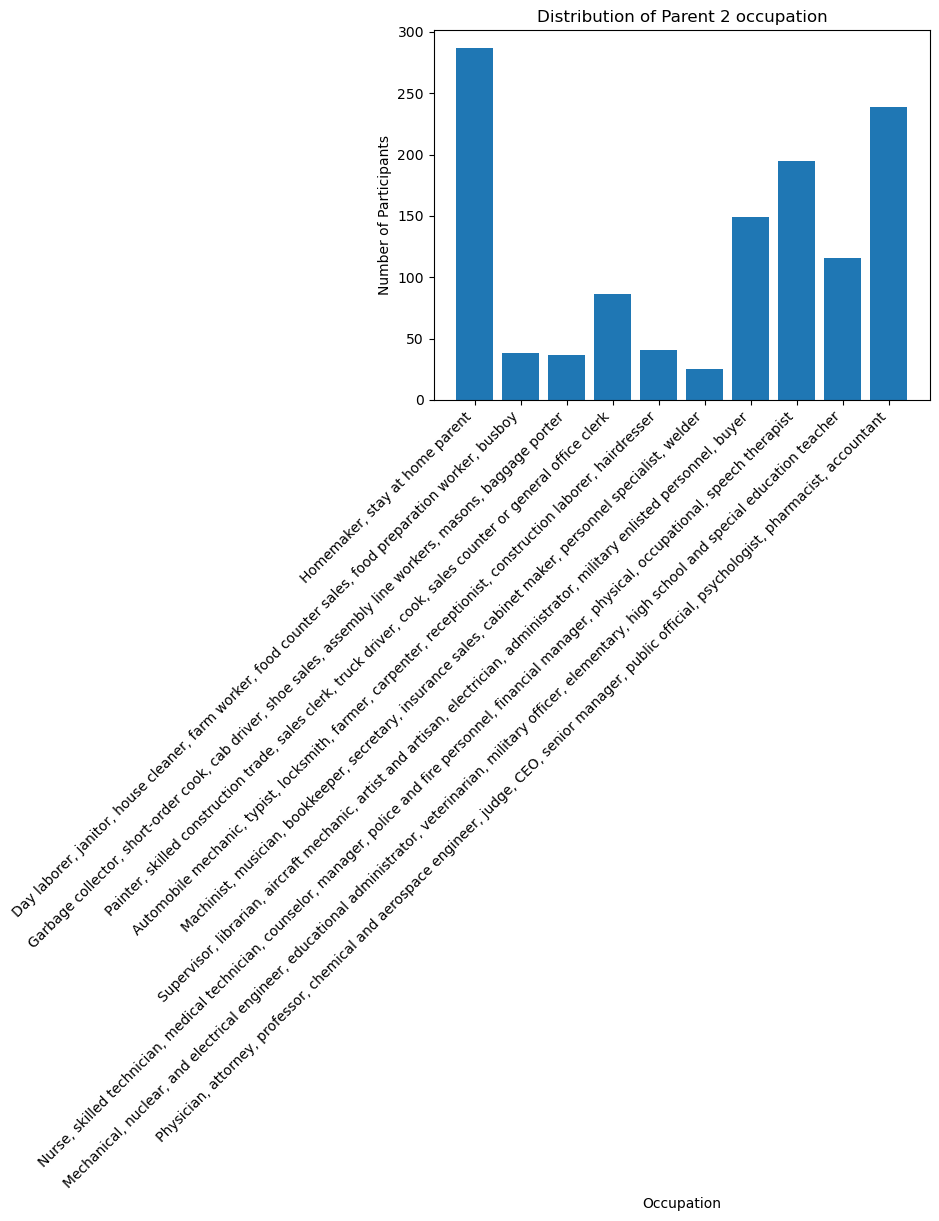

In [97]:
# Parent 2 Education Distribution
# Parent 2 Education Distribution
plt.figure(figsize=(10, 6))
edu_labels_dict = {
    0: 'Homemaker, stay at home parent',
    5: 'Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy',
    10: 'Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter',
    15: 'Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk',
    20: 'Automobile mechanic, typist, locksmith, farmer, carpenter, receptionist, construction laborer, hairdresser',
    25: 'Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder',
    30: 'Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer',
    35: 'Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist',
    40: 'Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher',
    45: 'Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant'
}

edu_counts = train['Barratt_Barratt_P1_Occ'].value_counts().sort_index()

# Use actual index values and corresponding labels
plt.bar(
    [edu_labels_dict.get(x, str(x)) for x in edu_counts.index], 
    edu_counts
)
plt.title('Distribution of Parent 1 occupation')
plt.xlabel('Occupation')
plt.ylabel('Number of Participants')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


edu_counts = train['Barratt_Barratt_P2_Occ'].value_counts().sort_index()

# Use actual index values and corresponding labels
plt.bar(
    [edu_labels_dict.get(x, str(x)) for x in edu_counts.index], 
    edu_counts
)
plt.title('Distribution of Parent 2 occupation')
plt.xlabel('Occupation')
plt.ylabel('Number of Participants')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

=== BRAIN CONNECTIVITY ANALYSIS ===
Number of brain connectivity features: 19902
First few connectivity features: ['0throw_1thcolumn', '0throw_2thcolumn', '0throw_3thcolumn', '0throw_4thcolumn', '0throw_5thcolumn']


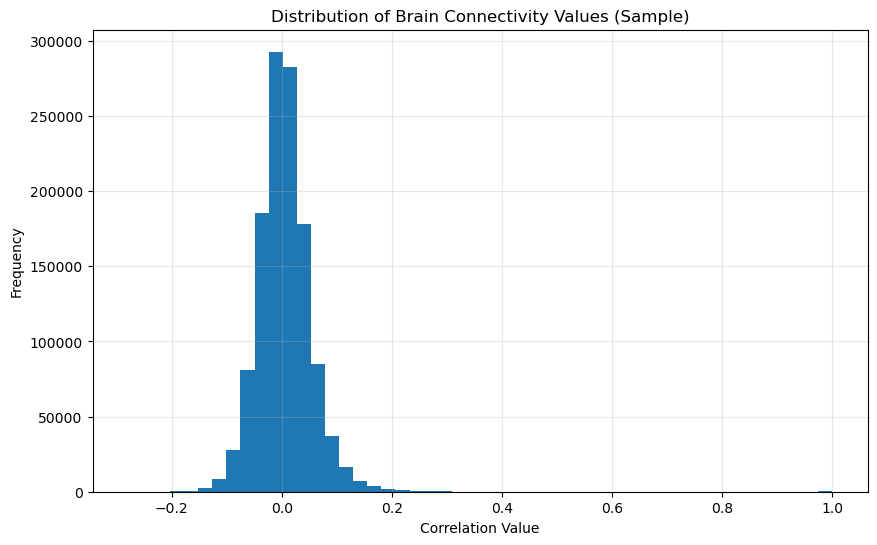

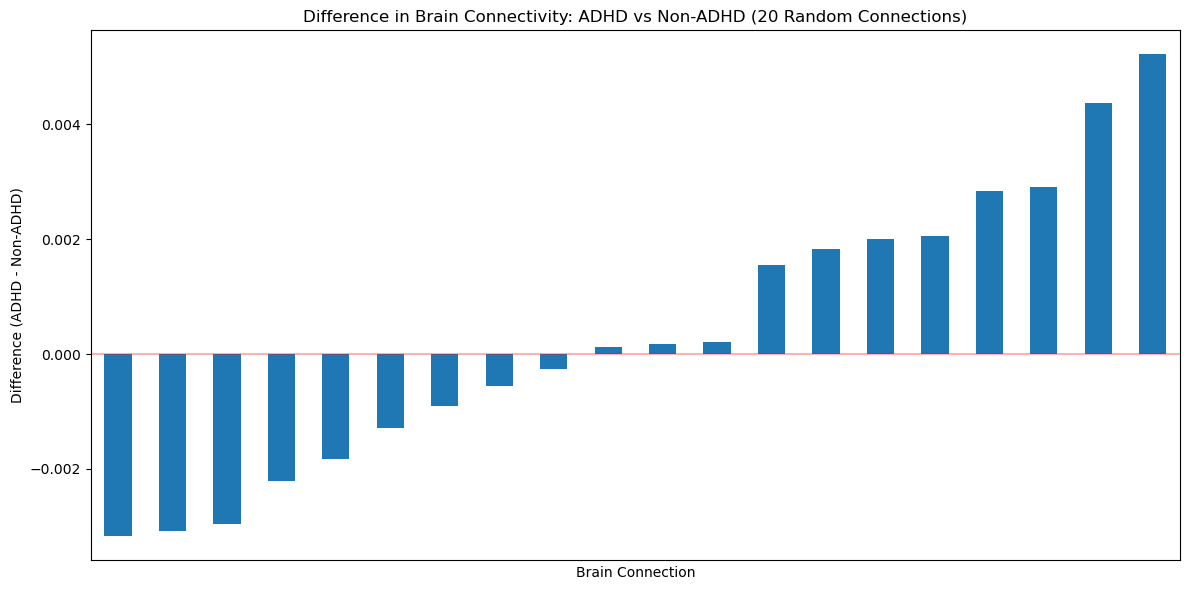

In [39]:
print("=== BRAIN CONNECTIVITY ANALYSIS ===")

# 1. Identify brain connectivity features
connectome_cols = [col for col in train.columns if (col.startswith('0') or col.startswith('1') or 
                                                    col.startswith('2') or col.startswith('3') or 
                                                    col.startswith('4') or col.startswith('5') or
                                                    col.startswith('6') or col.startswith('7') or
                                                    col.startswith('8') or col.startswith('9') or
                                                    col in targets)]

print(f"Number of brain connectivity features: {len(connectome_cols)}")
print(f"First few connectivity features: {connectome_cols[:5]}")

# 2. Distribution of connectivity values (sample)
plt.figure(figsize=(10, 6))
# Take a random sample to avoid memory issues
sample_size = min(1000, len(connectome_cols))
np.random.seed(42)
sample_cols = np.random.choice(connectome_cols, sample_size)
all_values = train[sample_cols].values.flatten()
all_values = all_values[~np.isnan(all_values)]  # Remove NaN values if any

plt.hist(all_values, bins=50)
plt.title('Distribution of Brain Connectivity Values (Sample)')
plt.xlabel('Correlation Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# 3. Simple visualization of connectivity difference between ADHD and non-ADHD
# Take just 20 random features for a simple comparison
sample_size = 20
np.random.seed(42)
tiny_sample = np.random.choice(connectome_cols, sample_size)

# Calculate means by group
adhd_means = train[train['ADHD_Outcome']==1][tiny_sample].mean()
non_adhd_means = train[train['ADHD_Outcome']==0][tiny_sample].mean()
diff = adhd_means - non_adhd_means

# Plot differences
plt.figure(figsize=(12, 6))
diff.sort_values().plot(kind='bar')
plt.title('Difference in Brain Connectivity: ADHD vs Non-ADHD (20 Random Connections)')
plt.xlabel('Brain Connection')
plt.ylabel('Difference (ADHD - Non-ADHD)')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xticks([])  # Hide feature names to avoid clutter
plt.tight_layout()
plt.show()


=== UNDERSTANDING BRAIN CONNECTIVITY DATA ===
Number of brain connectivity features: 19902
First few connectivity features: ['0throw_1thcolumn', '0throw_2thcolumn', '0throw_3thcolumn', '0throw_4thcolumn', '0throw_5thcolumn']

What do these features mean?
- Each feature (like '0throw_1stcolumn') represents the correlation between two brain regions
- Values range from -1 to +1
- Positive values: regions activate together
- Negative values: when one region activates, the other tends to deactivate
- Values close to zero: little relationship between regions

=== SAMPLE BRAIN CONNECTIVITY VALUES ===
For the first subject in our dataset:
0throw_1thcolumn: -0.0398
0throw_2thcolumn: 0.1776
0throw_3thcolumn: 0.0572
0throw_4thcolumn: 0.0376
0throw_5thcolumn: 0.1182

The histogram shows us how brain connectivity values are distributed.
Most values are centered around zero, with fewer strong positive or negative correlations.

=== COMPARING BRAIN CONNECTIVITY: ADHD VS NON-ADHD ===
                 

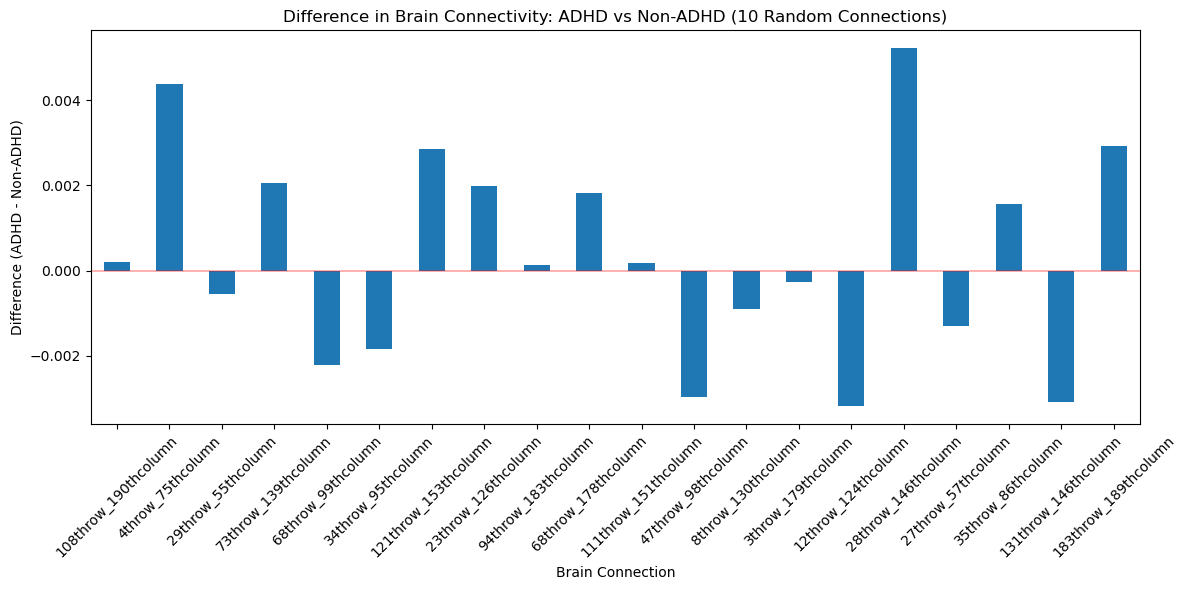


This bar chart shows differences in brain connectivity between ADHD and non-ADHD groups.
Bars above zero: connections stronger in ADHD subjects
Bars below zero: connections stronger in non-ADHD subjects
Even with just 10 random connections, we can see differences between the groups!


In [105]:

print("=== UNDERSTANDING BRAIN CONNECTIVITY DATA ===")

# 1. First, let's understand what our connectivity data looks like
connectome_cols = [col for col in train.columns if (col.startswith('0') or col.startswith('1') or 
                                                    col.startswith('2') or col.startswith('3') or 
                                                    col.startswith('4') or col.startswith('5') or
                                                    col.startswith('6') or col.startswith('7') or
                                                    col.startswith('8') or col.startswith('9') or
                                                    col in targets)]

print(f"Number of brain connectivity features: {len(connectome_cols)}")
print(f"First few connectivity features: {connectome_cols[:5]}")

print("\nWhat do these features mean?")
print("- Each feature (like '0throw_1stcolumn') represents the correlation between two brain regions")
print("- Values range from -1 to +1")
print("- Positive values: regions activate together")
print("- Negative values: when one region activates, the other tends to deactivate")
print("- Values close to zero: little relationship between regions")


# 3. Let's look at some sample connectivity values first
print("\n=== SAMPLE BRAIN CONNECTIVITY VALUES ===")
# Show a few sample values from the first subject
sample_subject = train.iloc[0]
print("For the first subject in our dataset:")
for i, col in enumerate(connectome_cols[:5]):
    print(f"{col}: {sample_subject[col]:.4f}")

print("\nThe histogram shows us how brain connectivity values are distributed.")
print("Most values are centered around zero, with fewer strong positive or negative correlations.")

# 5. Simple comparison between ADHD and non-ADHD
print("\n=== COMPARING BRAIN CONNECTIVITY: ADHD VS NON-ADHD ===")
# Take just 10 random features for a simple comparison
sample_size = 20
np.random.seed(42)
tiny_sample = np.random.choice(connectome_cols, sample_size)

# Calculate means by group
adhd_means = train[train['ADHD_Outcome']==1][tiny_sample].mean()
non_adhd_means = train[train['ADHD_Outcome']==0][tiny_sample].mean()
diff = adhd_means - non_adhd_means

# Create a comparative table
comparison = pd.DataFrame({
    'ADHD': adhd_means,
    'Non-ADHD': non_adhd_means,
    'Difference': diff
})
print(comparison.round(4))

# Plot differences
plt.figure(figsize=(12, 6))
diff.plot(kind='bar')
plt.title('Difference in Brain Connectivity: ADHD vs Non-ADHD (10 Random Connections)')
plt.xlabel('Brain Connection')
plt.ylabel('Difference (ADHD - Non-ADHD)')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nThis bar chart shows differences in brain connectivity between ADHD and non-ADHD groups.")
print("Bars above zero: connections stronger in ADHD subjects")
print("Bars below zero: connections stronger in non-ADHD subjects")
print("Even with just 10 random connections, we can see differences between the groups!")

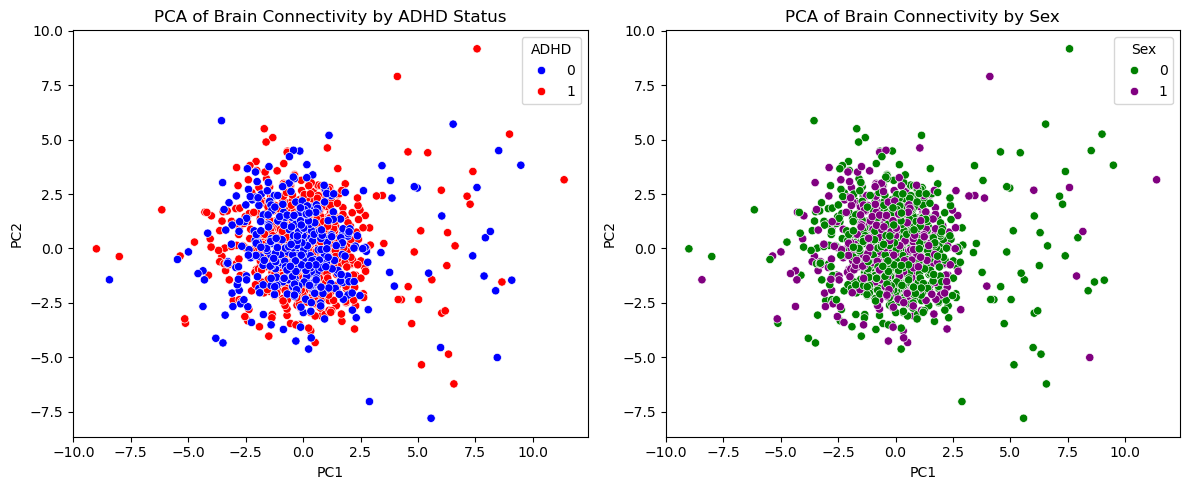

Variance explained by PC1: 0.79%
Variance explained by PC2: 0.62%


In [107]:

# 4. Simple PCA on a subset of connectivity features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Take 500 random features for PCA
sample_size = min(500, len(connectome_cols)) 
np.random.seed(42)
pca_sample = np.random.choice(connectome_cols, sample_size)

# Standardize the data
X = train[pca_sample].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'ADHD': train['ADHD_Outcome'].values,
    'Sex': train['Sex_F'].values
})

# Plot PCA results
plt.figure(figsize=(12, 5))

# By ADHD
plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='ADHD', data=pca_df, palette=['blue', 'red'])
plt.title('PCA of Brain Connectivity by ADHD Status')

# By Sex
plt.subplot(1, 2, 2)
sns.scatterplot(x='PC1', y='PC2', hue='Sex', data=pca_df, palette=['green', 'purple'])
plt.title('PCA of Brain Connectivity by Sex')

plt.tight_layout()
plt.show()

# Print explained variance
print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")

# Testing

In [1]:
%%time

import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load Data
df_fmri = pd.read_csv("Dataset/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv")
df_labels = pd.read_excel("Dataset/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx")

# Merge labels
df_fmri = df_fmri.merge(df_labels, on="participant_id")

# Extract target (Sex: 0=Female, 1=Male)
y = df_fmri["Sex_F"].values
X = df_fmri.drop(columns=["participant_id", "Sex_F", "ADHD_Outcome"]).values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PLS Regression for Dimensionality Reduction
n_components = 10  # Adjust this based on explained variance
pls = PLSRegression(n_components=n_components)

# Define 10-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Train Logistic Regression on PLS Features using Cross-Validation
clf = LogisticRegression(random_state=42)
scores = cross_val_score(clf, pls.fit_transform(X_scaled, y)[0], y, cv=cv, scoring="f1_micro")

print(f"10-Fold CV F1_Micro: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


10-Fold CV F1_Micro: 1.0000 ± 0.0000


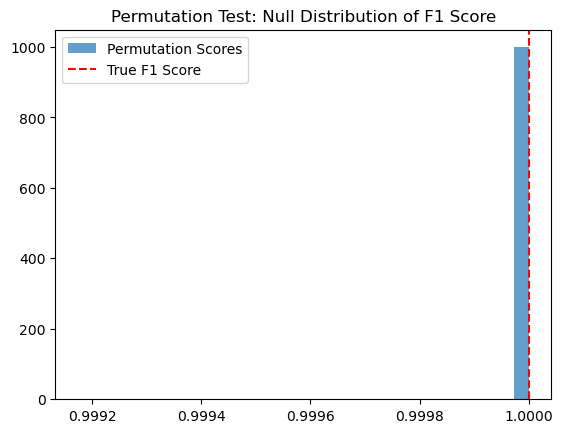

P-value: 0.9990 (Lower = More Significant)


In [3]:
%%time

import matplotlib.pyplot as plt

n_permutations = 1000
perm_scores = []

for _ in range(n_permutations):
    np.random.shuffle(y)  # Shuffle labels
    perm_score = np.mean(cross_val_score(clf, pls.fit_transform(X_scaled, y)[0], y, cv=cv, scoring="f1_micro"))
    perm_scores.append(perm_score)

# Compare real accuracy with permutation distribution
plt.hist(perm_scores, bins=30, alpha=0.7, label="Permutation Scores")
plt.axvline(np.mean(scores), color="red", linestyle="dashed", label="True F1 Score")
plt.legend()
plt.title("Permutation Test: Null Distribution of F1 Score")
plt.show()

# Compute p-value
p_value = np.mean(np.array(perm_scores) >= np.mean(scores))
print(f"P-value: {p_value:.4f} (Lower = More Significant)")


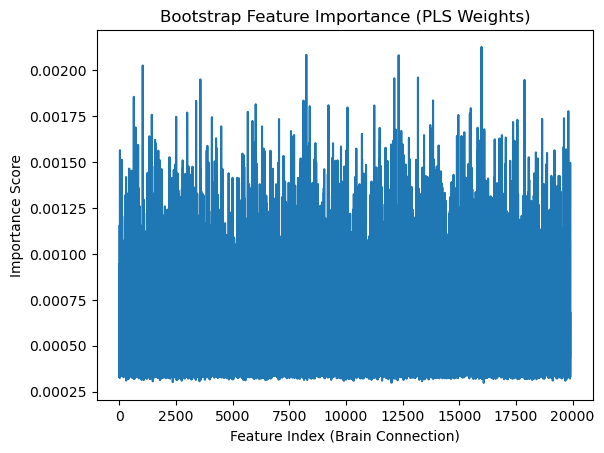

In [4]:
%%times

n_bootstrap = 1000
bootstrap_weights = np.zeros((n_bootstrap, X_scaled.shape[1]))

for i in range(n_bootstrap):
    sample_idx = np.random.choice(range(X_scaled.shape[0]), size=X_scaled.shape[0], replace=True)
    X_sample = X_scaled[sample_idx]
    y_sample = y[sample_idx]
    
    pls.fit(X_sample, y_sample)
    bootstrap_weights[i] = np.abs(pls.coef_).flatten()

# Compute mean bootstrap importance scores
feature_importance = np.mean(bootstrap_weights, axis=0)

# Plot feature importance
plt.plot(feature_importance)
plt.title("Bootstrap Feature Importance (PLS Weights)")
plt.xlabel("Feature Index (Brain Connection)")
plt.ylabel("Importance Score")
plt.show()
